In [77]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from numpy.random import RandomState
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
import re
import glob
pd.set_option('display.max_colwidth', -1)
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if sys.path[0] == '':


In [250]:
labeled_data = pd.read_pickle('./data/labeled_data_df.pkl')
labeled_data.shape

(683715, 5)

In [251]:
labeled_data.type.value_counts()

twint_tweet               520886
dallas_news_predicted     114686
dallas_news               40309 
mturk_french_backtrans    2050  
mturk                     2050  
mturk_zh_backtrans        2050  
mturk_high_iaa            1120  
semeval_train_tweets      395   
semeval_tweets            169   
Name: type, dtype: int64

In [4]:
labeled_data.columns

Index(['source', 'type', 'text', 'stance', 'nli_label'], dtype='object')

In [229]:
stances = ["agree", "neutral", "disagree"]
class_nums = {s: i for i, s in enumerate(stances)}
stance2nli = {'agree':'entailment','neutral':'neutral','disagree':'contradiction',
             'agrees':'entailment','disagrees':'contradiction'}

In [235]:
labeled_data.head()

,source,type,text,stance,nli_label
0,climate_change1.0-12174 [SEP] 0,dallas_news,It's about seeing the forest and the trees in Calif.; Scientists study global warming's effect on redwoods and sequoias,agree,entailment
1,climate_change1.0-12174 [SEP] 1,dallas_news,Two of his colleagues dangled on ropes 100 feet above from the gnarled branches of a giant sequoia tree.,agree,entailment
2,climate_change1.0-12174 [SEP] 2,dallas_news,Steve Sillett could hardly contain his excitement.,agree,entailment
3,climate_change1.0-12174 [SEP] 3,dallas_news,"""This site is just juicy.",agree,entailment
4,climate_change1.0-12174 [SEP] 4,dallas_news,"It's loaded,"" said Sillett, gazing up at the ancient canopy at Calaveras Big Trees State Park.",agree,entailment


In [249]:
#labeled_data.to_pickle('./data/labeled_data_df.pkl')

# Vaccines data

In [115]:
vax_dir = '/Users/yiweiluo/vaccination_stance'

In [116]:
vax_stances = ['for','uncertain','against']
vax_class_nums = {s: i for i, s in enumerate(vax_stances)}

In [113]:
vax_labeled_dat = {'type':[],'text':[],'stance':[]}
#vax_labeled_dat_df = pd.read_pickle('./data/vax_labeled_data_df.pkl')

## Get Skeppstedt annotated forum data

In [167]:
for_files = glob.glob(os.path.join(vax_dir,'train_data','for','*.txt'))
uncertain_files = glob.glob(os.path.join(vax_dir,'train_data','uncertain','*.txt'))
against_files = glob.glob(os.path.join(vax_dir,'train_data','against','*.txt'))
len(for_files),len(uncertain_files),len(against_files)

(430, 238, 462)

In [168]:
for_texts = []
for file in for_files:
    with open(file,'r') as f:
        for_texts.append(f.read().strip())
        
uncertain_texts = []
for file in uncertain_files:
    with open(file,'r') as f:
        uncertain_texts.append(f.read().strip())
        
against_texts = []
for file in against_files:
    with open(file,'r') as f:
        against_texts.append(f.read().strip())
        
len(for_texts),len(uncertain_texts),len(against_texts)

(430, 238, 462)

In [169]:
sentences = for_texts + uncertain_texts + against_texts 
len(sentences)

1130

In [119]:
texts_by_stance = {'for':for_texts,'uncertain':uncertain_texts,'against':against_texts}

In [170]:
for_texts[5] 
# Skeppstedt data is multiple sentences. Split? But individual sentence might not reflect overall stance...

'Rosi, one very anti-vaccine doctor only goes to prove that one doctor is against vaccination, not that vaccines are dangerous. One smoking doctor does not prove that smoking is harmless, just that doctors are humans and can be irrational. Loibner, who has been an anti-vaccine activist for decades, is really not suitable as a proof for a recent trend in vaccine refusal amongst doctors.'

In [120]:
for stance in vax_stances:
    vax_labeled_dat['type'].extend(['skeppstedt']*len(texts_by_stance[stance]))
    vax_labeled_dat['stance'].extend([stance]*len(texts_by_stance[stance]))
    vax_labeled_dat['text'].extend(texts_by_stance[stance])

In [121]:
vax_labeled_dat_df = pd.DataFrame(vax_labeled_dat)

In [122]:
vax_labeled_dat_df.shape

(1130, 3)

## My manually annotated clauses

In [123]:
vax_label_dict = {0: 'for', 1: 'against', 2: 'neutral'}

In [106]:
base_dir = '/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/'
anti_tetrads_results = pd.read_csv(base_dir+'on_topic_anti_vax_tetrads_with_subject_verb_filtered.csv',header=None,
                                  encoding = "ISO-8859-1")
pro_tetrads_results = pd.read_csv(base_dir+'on_topic_pro_vax_tetrads_with_subject_verb_filtered.csv',header=None,
                                  encoding = "ISO-8859-1")

In [108]:
anti_tetrads_results.columns = ['subj','neg','v','sentence','stance','source','notes','subj_ent']
pro_tetrads_results.columns = ['subj','neg','v','sentence','stance','source','notes','subj_ent']
all_manual_vax = anti_tetrads_results.append(pro_tetrads_results,ignore_index=True)

In [109]:
all_manual_vax

,subj,neg,v,sentence,stance,source,notes,subj_ent
0,authors,NaN,acknowledged,that â such an outbreak should have been virtually impossible,0,sent_no_26 of https://childrenshealthdefense.org/news/herd-immunity-a-false-rationale-for-vaccine-mandates/,NaN,s
1,.I,NaN,say,tics are four times more prevalent in kids with autism,1,sent_no_17 of https://childrenshealthdefense.org/uncategorized/cdc-scientist-still-maintains-agency-forced-researchers-lie-safety-mercury-based-vaccines/,NaN,NaN
2,New York Times,NaN,claimed,that the science showed that the vaccine represented â a big payoff in public health â and that harms from the vaccine were â almost nonexistent â,0,sent_no_4 of https://childrenshealthdefense.org/news/how-the-cdc-uses-fear-to-increase-demand-for-flu-vaccines/,NaN,p
3,I,NaN,say,tics are four times more prevalent in kids with autism,1,sent_no_67 of https://childrenshealthdefense.org/news/get-flu-shot-cdc-data-raise-concerns/,NaN,NaN
4,awards,NaN,recognize,that many of the chronic diseases that suddenly became epidemic in our children following the passage of NCVIA can be caused by vaccines or their ingredients,1,sent_no_53 of https://childrenshealthdefense.org/news/vaccines-and-the-liberal-mind/,NaN,NaN
...,...,...,...,...,...,...,...,...
995,Rabinowitz,NaN,added,"that for patients with celiac disease , vaccines such as the flu vaccine are very important",0,sent_no_18 of https://www.foxnews.com/health/some-people-who-avoid-gluten-also-avoid-vaccines,NaN,doc
996,it,NaN,ensure,"that it is not influenced by politics , such as pressure from officials to play down an outbreak that may affect tourism or trade , in raising international alarms",2,sent_no_15 of https://www.nytimes.com/2015/12/30/opinion/nearing-triumph-over-ebola.html?searchResultPosition=3,NaN,NaN
997,committee,NaN,decided,that nasal flu vaccine (the brand name is FluMist) nasal flu vaccine (the brand name is FluMist) nasal flu vaccine (the brand name is FluMist) nasal flu vaccine (the brand name is FluMist) nasal flu vaccine (the brand name is FluMist) nasal flu vaccine (the brand name is FluMist) nasal flu vaccine (the brand name is FluMist) nasal flu vaccine (the brand name is FluMist) nasal flu vaccine (the brand name is FluMist) nasal flu vaccine (the brand name is FluMist) should no longer be used because it has been less effective in protecting people the past couple of flu seasons,2,sent_no_3 of https://www.nytimes.com/2016/10/03/well/family/a-flu-season-without-flumist-making-shots-less-painful-for-children.html?searchResultPosition=66,NaN,dept
998,i,NaN,reassure,that vaccines are safe,0,sent_no_8 of https://www.foxnews.com/health/with-most-cases-centering-on-new-york-city-us-measles-count-nears-1000-toppling-records,NaN,NaN


In [110]:
all_manual_vax.stance.value_counts()

2    497
1    265
0    238
Name: stance, dtype: int64

In [111]:
497+265+238

1000

In [125]:
texts_by_stance = {'for':all_manual_vax.loc[all_manual_vax.stance==0].sentence.values,
                   'uncertain':all_manual_vax.loc[all_manual_vax.stance==2].sentence.values,
                   'against':all_manual_vax.loc[all_manual_vax.stance==1].sentence.values,}

In [126]:
for stance in vax_stances:
    vax_labeled_dat['type'].extend(['my_annotations']*len(texts_by_stance[stance]))
    vax_labeled_dat['stance'].extend([stance]*len(texts_by_stance[stance]))
    vax_labeled_dat['text'].extend(texts_by_stance[stance])

In [127]:
vax_labeled_dat_df = pd.DataFrame(vax_labeled_dat)
vax_labeled_dat_df.shape

(2130, 3)

In [128]:
vax_labeled_dat_df.to_pickle('./data/vax_labeled_data_df.pkl')

## Unlabeled vaccine data for LM fine-tuning

In [170]:
for_files = glob.glob(os.path.join(vax_dir,'my_train_data','for','*.txt'))
uncertain_files = glob.glob(os.path.join(vax_dir,'my_train_data','uncertain','*.txt'))
against_files = glob.glob(os.path.join(vax_dir,'my_train_data','against','*.txt'))
len(for_files),len(uncertain_files),len(against_files)

(434, 127, 933)

In [171]:
for_texts = []
for file in for_files:
    with open(file,'r') as f:
        for_texts.append(f.read().strip().replace('\t',''))
        
uncertain_texts = []
for file in uncertain_files:
    with open(file,'r') as f:
        uncertain_texts.append(f.read().strip().replace('\t',''))
        
against_texts = []
for file in against_files:
    with open(file,'r') as f:
        against_texts.append(f.read().strip().replace('\t',''))
        
len(for_texts),len(uncertain_texts),len(against_texts)

(434, 127, 933)

In [172]:
print(len(sentences))
sentences.extend(for_texts + uncertain_texts + against_texts)
print(len(sentences))

1130
2624


In [179]:
df = pd.read_pickle('../../data_scraping/dedup_combined_df.pkl')
df.head(10)

,url,title,date,domain,stance,topic,is_AP,year,pretty_domain
0,www.buzzfeednews.com/article/tasneemnashrulla/eat-babies-aoc-town-hall-pro-trump-troll-larouche,"""eat the babies"" viral video at aoc town hall was staged ...",2019-10-04 00:00:00,buzzfeed,pro,cc,None,2019.0,Buzzfeed
1,www.buzzfeednews.com/article/passantino/extremely-likely-global-warming-is-man-made-climate-scientis,"""extremely likely"" global warming is man-made, climate ...",2013-09-27 00:00:00,buzzfeed,pro,cc,None,2013.0,Buzzfeed
2,shotofprevention.com/2010/11/03/history-makes-headlines-with-launch-of-new-website/,"""history"" makes headlines with launch of new website",2020-03-13 14:32:02,https://shotofprevention/,pro,vax,False,2020.0,Shot of Prevention
3,www.buzzfeednews.com/article/andrewkaczynski/its-global-warming-stupid,"""it's global warming, stupid"" - buzzfeed news",2012-11-01 00:00:00,buzzfeed,pro,cc,None,2012.0,Buzzfeed
4,www.buzzfeednews.com/article/tasneemnashrulla/japan-dropped-an-atomic-bomb-on-america-during-world-war-ii,"""japan dropped an atomic bomb on america during world ...",2014-02-24 00:00:00,buzzfeed,pro,cc,None,2014.0,Buzzfeed
5,www.buzzfeednews.com/article/llevin/opinion-im-18-and-joe-biden-couldnt-answer-my-questions-how,"""look at my record, child"": joe biden showed me he's not ...",2019-10-31 00:00:00,buzzfeed,pro,cc,None,2019.0,Buzzfeed
6,www.breitbart.com/politics/2019/06/14/orourke-president-orourke-will-take-executive-action-to-end-new-oil-and-gas-leases-on-federal-lands/,"""president o'rourke will end oil and gas leases on federal ...",2019-06-14 00:00:00,breitbart,anti,cc,None,2019.0,Breitbart
7,www.buzzfeednews.com/article/andrewkaczynski/smoking-doesnt-kill-and-other-great-old-op-eds-from-mike-pen,smoking doesnt kill and other great old opeds from mike pence,2015-03-31 00:00:00,buzzfeed,pro,cc,None,2015.0,Buzzfeed
8,www.foxnews.com/world/100-carbon-tax-by-2030-could-save-climate-say-economists,"$100 carbon tax by 2030 could save climate, say economists ...",2017-05-29 00:00:00,fox,anti,cc,None,2017.0,Fox
21585,childrenshealthdefense.org/news/4-billion-and-growing-u-s-payouts-for-vaccine-injuries-and-deaths-keep-climbing/,$4 billion and growing: u.s. payouts for vaccine injuries and deaths keep climbing,2018-11-19 00:00:00,chd,anti,vax,None,2018.0,Children's Health Defense


In [180]:
vax_df = df.loc[df.topic == 'vax']
vax_df.shape

(2530, 9)

In [181]:
os.chdir('../../')
print(os.getcwd())
from utils import get_fulltext,get_fname,fulltext_exists
os.chdir('./cc_stance/data_creation/')

/Users/yiweiluo/scientific-debates


In [185]:
train_ix,test_ix = train_test_split(list(range(len(sentences))),test_size=0.3)
len(train_ix),len(test_ix)

(1836, 788)

In [186]:
train_ix,test_ix = train_test_split(list(range(len(sentences))),test_size=0.3)
len(train_ix),len(test_ix)

(1836, 788)

In [187]:
train_sents = [sentences[ix] for ix in train_ix]
test_sents = [sentences[ix] for ix in test_ix]
len(train_sents),len(test_sents)

(1836, 788)

In [188]:
train_sents[:3]

['In addition to those 400 chronic diseases and injuries that FDA suspects may be vaccine related, the vaccine generation suffers unprecedented levels of anxiety and depression and behavioral disorders running the gamut from aggression to anorexia.',
 'The types of studies the CDC has relied on to support this claim have been thoroughly discredited due to their systemic “healthy user” selection bias, and the mortality rate has observably increased along with the increase in vaccine uptake—which the CDC has encouraged with its unevidenced claims about the vaccine’s benefits, downplaying of its risks, and a marketing strategy of trying to frighten people into getting the flu shot for themselves and their family.',
 'Titre studies are unable to differentiate vaccine derived antibodies and those derived from natural infection so it is felt transfer in colostrum is no different in fact studies in cattle and sheep have shown it is not. The most effective antibody transfer occurs in colostrum

In [184]:
vax_df_train,vax_df_test = train_test_split(vax_df.url.values,test_size=0.2)
len(vax_df_train),len(vax_df_test)

(2024, 506)

In [192]:
with open('all.vax.fulltexts.uncased.train.raw','w+') as f:
    for url in vax_df_train:
        f.write(' '.join(get_fulltext(url)).lower())
        f.write('\n')
    for s in train_sents:
        f.write(s.lower()+' ')
        
with open('all.vax.fulltexts.uncased.test.raw','w+') as f:
    for url in vax_df_test:
        f.write(' '.join(get_fulltext(url)).lower())
        f.write('\n')
    for s in test_sents:
        f.write(s.lower()+' ')

## Create train/test/dev splits

In [193]:
data_type = 'vanilla' # 'my_annotations','skeppstedt','both_vax',None
do_downsample = False

if do_downsample:
    SAVE_DIR = './scripts/save/{}_downsampled/'.format(data_type)
else:
    SAVE_DIR = './scripts/save/{}/'.format(data_type)
print(SAVE_DIR)
if not os.path.exists(SAVE_DIR):
    os.mkdir(SAVE_DIR)

if data_type != 'both_vax':
    data_df = vax_labeled_dat_df.loc[vax_labeled_dat_df.type == data_type]
else:
    data_df = vax_labeled_dat_df

if data_df is not None:
    print(data_df.shape) 

./scripts/save/vanilla/
(0, 3)


In [150]:
vax_labeled_dat_df.index

RangeIndex(start=0, stop=2130, step=1)

In [151]:
train_ix,eval_ix = train_test_split(vax_labeled_dat_df.loc[vax_labeled_dat_df.type=='my_annotations']\
                                    .index.values,test_size=300)
len(train_ix),len(eval_ix)

(700, 300)

In [152]:
SHARED_EVAL_IX = eval_ix.copy()

In [153]:
dev_ix,test_ix = train_test_split(eval_ix,test_size=200)
len(dev_ix),len(test_ix)

(100, 200)

In [155]:
train_df = data_df[~data_df.index.isin(SHARED_EVAL_IX)]
dev_df = data_df.loc[dev_ix]
test_df = data_df.loc[test_ix]
print(train_df.shape,dev_df.shape,test_df.shape)

(1830, 3) (100, 3) (200, 3)


## Writing to files

In [156]:
train_df_by_stance = {s: train_df.loc[train_df.stance == s] for s in vax_stances} if train_df is not None else None
dev_df_by_stance = {s: dev_df.loc[dev_df.stance == s] for s in vax_stances}
test_df_by_stance = {s: test_df.loc[test_df.stance == s] for s in vax_stances}

train_X_by_stance = {s: train_df_by_stance[s].text.values for i,s in enumerate(vax_stances)} if train_df is not None else None
dev_X_by_stance = {s: dev_df_by_stance[s].text.values for i,s in enumerate(vax_stances)}
test_X_by_stance = {s: test_df_by_stance[s].text.values for i,s in enumerate(vax_stances)}

train_Y_by_stance = {s: np.array([vax_class_nums[x] for x in train_df_by_stance[s].stance]) for i,s in enumerate(vax_stances)} if train_df is not None else None
dev_Y_by_stance = {s: np.array([vax_class_nums[x] for x in dev_df_by_stance[s].stance]) for i,s in enumerate(vax_stances)}
test_Y_by_stance = {s: np.array([vax_class_nums[x] for x in test_df_by_stance[s].stance]) for i,s in enumerate(vax_stances)}

if do_downsample:
    min_N = min([len(train_X_by_stance[s]) for s in vax_stances])
    print('Downsampling to ~{} examples per stance.'.format(min_N))
    for s in vax_stances:
        train_X_by_stance[s] = train_X_by_stance[s][:min_N+50]

if train_df is not None:
    trX = []
    trY = []
    for i,s in enumerate(vax_stances):
        for t, y in zip(train_X_by_stance[s], train_Y_by_stance[s]):
            trX.append(t)
            trY.append(y)

teX = []
teY = []
for i,s in enumerate(vax_stances):
    for t, y in zip(test_X_by_stance[s], test_Y_by_stance[s]):
        teX.append(t)
        teY.append(y)

vaX = []
vaY = []
for i,s in enumerate(vax_stances):
    for t, y in zip(dev_X_by_stance[s], dev_Y_by_stance[s]):
        vaX.append(t)
        vaY.append(y)
        
        
test_dat = pd.DataFrame({'sentence':teX,'stance':teY})
train_dat = pd.DataFrame({'sentence':trX,'stance':trY}) if train_df is not None else None
val_dat = pd.DataFrame({'sentence':vaX,'stance':vaY})
if train_df is not None:
    print('Train distribution:')
    print(train_dat.stance.value_counts()) 
print('\nDev distribution:')
print(val_dat.stance.value_counts())
print('\nTest distribution:')
print(test_dat.stance.value_counts())

if train_df is not None:
    train_dat.to_csv(SAVE_DIR+'train.tsv',sep='\t',header=None,index=False)
val_dat.to_csv(SAVE_DIR+'dev.tsv',sep='\t',header=None,index=False)
test_dat.to_csv(SAVE_DIR+'test.tsv',sep='\t',header=None,index=False)

Train distribution:
2    649
0    610
1    571
Name: stance, dtype: int64

Dev distribution:
1    56
2    26
0    18
Name: stance, dtype: int64

Test distribution:
1    108
2    52 
0    40 
Name: stance, dtype: int64


# Vanilla MTurk--Dallas estimated true labels

In [ ]:
dallas_sentence_scores = pd.read_csv('/Users/yiweiluo/scientific-debates/\
cc_stance/MTurk/MTurk_results/sent_scores_df.tsv',delimiter='\t')
dallas_sentence_scores['max_prob_label'] = dallas_sentence_scores[['disagree',
                                                                  'neutral',
                                                                  'agree']].idxmax(axis=1)
dallas_sentence_scores.shape

In [ ]:
mturk_data_df = pd.DataFrame({
    'source':['round{}_batch{}_sentid{}'.format(row['round'],
                                                              row['batch'],
                                                              row['sent_id'])
                              for ix,row in dallas_sentence_scores.iterrows()],
    'type':['mturk']*len(dallas_sentence_scores),
    'text':[row['sentence'] for ix,row in 
                             dallas_sentence_scores.iterrows()],
    'stance':[row['max_prob_label'] for ix,row in 
                             dallas_sentence_scores.iterrows()]
})
mturk_data_df.shape

In [ ]:
labeled_data['source'].extend(['round{}_batch{}_sentid{}'.format(row['round'],
                                                              row['batch'],
                                                              row['sent_id'])
                              for ix,row in dallas_sentence_scores.iterrows()])
labeled_data['type'].extend(['mturk']*len(dallas_sentence_scores))
labeled_data['text'].extend([row['sentence'] for ix,row in 
                             dallas_sentence_scores.iterrows()])
labeled_data['stance'].extend([row['max_prob_label'] for ix,row in 
                             dallas_sentence_scores.iterrows()])
labeled_data_df = pd.DataFrame(labeled_data)
labeled_data_df.head(10)

In [57]:
mturk_df.stance.value_counts()

neutral     863
agree       783
disagree    404
Name: stance, dtype: int64

# Vanilla MTurk -- subset to high IAA

In [191]:
all_round_data = {r: {} for r in range(1,6)}
for round_no in range(1,6):
    all_round_data[round_no] = pickle.load(open('/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/\
LIVE_ROUND{}_BATCH_DATA.pkl'.format(round_no),'rb'))

In [227]:
PROP_AGREE = 0.75

In [204]:
worker_labels_per_round = pickle.load(open('../MTurk/MTurk_results/full_ratings_per_round.pkl','rb'))

In [230]:
src_df,type_df,text_df,stance_df,nli_label_df = [],[],[],[],[]
for r in range(1,6):
    for b in range(0,10):
        labels = worker_labels_per_round[r][b]
        for s_id in labels.index[5:-1]:
            source = 'round{}_batch{}_sentid{}'.format(r,b,s_id)
            type_ = 'mturk_high_iaa'
            text = labels.loc[s_id].sentence
            ratings = labels.loc[s_id][['worker_{}'.format(w_id) for w_id in range(0,8)]].values
            counted_ratings = Counter(ratings)
            top_rating = counted_ratings.most_common()[0]
            if top_rating[-1] >= PROP_AGREE*8:
                stance = top_rating[0]
                nli_label = stance2nli[stance]
                src_df.append(source)
                type_df.append(type_)
                text_df.append(text)
                stance_df.append(stance)
                nli_label_df.append(nli_label)

In [231]:
high_iaa_mturk_df = pd.DataFrame({'source':src_df,"type":type_df,"text":text_df,"stance":stance_df,
                                 "nli_label":nli_label_df})

In [241]:
dedup_high_iaa_mturk_df = high_iaa_mturk_df.drop_duplicates('text',keep='first')
dedup_high_iaa_mturk_df.shape,high_iaa_mturk_df.shape

((1120, 5), (1124, 5))

In [248]:
labeled_data = labeled_data.append(dedup_high_iaa_mturk_df,ignore_index=True)

# Add back translations

In [323]:
back_trans_fr = pd.read_csv('../data/mturk_french_backtranslations.tsv',sep='\t',
                        header=0,index_col=0)

In [ ]:
# need to make sure that whatever is chosen for test set, train set doesn't contain original source text 

In [194]:
#back_trans_df.head()

In [95]:
train_ix,test_ix = train_test_split(list(mturk_df.index),test_size=0.25)

In [96]:
len(train_ix),len(test_ix)
# To include w/ backtranslated training data; to exclude from backtranslated portion of training data

(1537, 513)

In [193]:
test_df = mturk_df.loc[test_ix]
#test_df

In [99]:
mturk_test_sources = set(mturk_df.loc[test_ix].source.values)
backtrans_train_df = back_trans_df.loc[~back_trans_df.source.isin(mturk_test_sources)]
backtrans_train_df.shape

(1537, 4)

In [100]:
train_df = mturk_df.loc[train_ix].append(backtrans_train_df)

In [101]:
# Make sure that train/test have no overlap in source
set(train_df.source.values).intersection(set(test_df.source.values))

set()

In [102]:
# It's okay for backtrans_train_df and mturk_df[train_ix] to have source overlap
# In fact, we expect overlap to be exactly 2050-len(test_df)
len(set(mturk_df.loc[train_ix].source.values).intersection(backtrans_train_df.source.values))

1537

In [103]:
2050-len(test_df)

1537

In [104]:
train_df.shape,test_df.shape

((3074, 4), (513, 4))

In [105]:
# split test_df into test and val dfs:
val_ix,test_ix = train_test_split(list(test_df.index),test_size=0.6)
print(len(val_ix),len(test_ix))
val_df = test_df.loc[val_ix]
test_df = test_df.loc[test_ix]
print(val_df.shape,test_df.shape)

205 308
(205, 4) (308, 4)


In [106]:
stances = ["agree", "neutral", "disagree"]
class_nums = {s: i for i, s in enumerate(stances)}

train_df_by_stance = {s: train_df.loc[train_df.stance == s] for s in stances}
val_df_by_stance = {s: val_df.loc[val_df.stance == s] for s in stances}
test_df_by_stance = {s: test_df.loc[test_df.stance == s] for s in stances}

train_X_by_stance = {s: train_df_by_stance[s].text.values for i,s in enumerate(stances)}
dev_X_by_stance = {s: val_df_by_stance[s].text.values for i,s in enumerate(stances)}
test_X_by_stance = {s: test_df_by_stance[s].text.values for i,s in enumerate(stances)}

train_Y_by_stance = {s: np.array([class_nums[x] for x in train_df_by_stance[s].stance]) for i,s in enumerate(stances)}
dev_Y_by_stance = {s: np.array([class_nums[x] for x in val_df_by_stance[s].stance]) for i,s in enumerate(stances)}
test_Y_by_stance = {s: np.array([class_nums[x] for x in test_df_by_stance[s].stance]) for i,s in enumerate(stances)}
#print(train_Y_by_stance)

# if args.downsample:
#     min_N = min([len(train_X_by_stance[s]) for s in stances])
#     print('Downsampling to ~{} examples per stance.'.format(min_N))
#     for s in stances:
#         train_X_by_stance[s] = train_X_by_stance[s][:min_N+200]

trX = []
trY = []
for i,s in enumerate(stances):
    for t, y in zip(train_X_by_stance[s], train_Y_by_stance[s]):
        trX.append(t)
        trY.append(y)

teX = []
teY = []
for i,s in enumerate(stances):
    for t, y in zip(test_X_by_stance[s], test_Y_by_stance[s]):
        teX.append(t)
        teY.append(y)

vaX = []
vaY = []
for i,s in enumerate(stances):
    for t, y in zip(dev_X_by_stance[s], dev_Y_by_stance[s]):
        vaX.append(t)
        vaY.append(y)
        
        
test_df = pd.DataFrame({'sentence':teX,'stance':teY})
train_df = pd.DataFrame({'sentence':trX,'stance':trY})
val_df = pd.DataFrame({'sentence':vaX,'stance':vaY})
print(test_df.stance.value_counts())
print(train_df.stance.value_counts())
print(val_df.stance.value_counts())

# save_path = Path(save_dir)/desc
# os.mkdir(save_path)
# test_df.to_csv(save_path/'test.tsv',sep='\t',header=None,index=False)
# train_df.to_csv(save_path/'train.tsv',sep='\t',header=None,index=False)
# val_df.to_csv(save_path/'dev.tsv',sep='\t',header=None,index=False)

1    129
0    122
2    57 
Name: stance, dtype: int64
1    1288
0    1172
2    614 
Name: stance, dtype: int64
1    90
0    75
2    40
Name: stance, dtype: int64


In [107]:
test_df.to_csv('./scripts/save/mturk_with_backtrans/test.tsv',sep='\t',header=None,index=False)
train_df.to_csv('./scripts/save/mturk_with_backtrans/train.tsv',sep='\t',header=None,index=False)
val_df.to_csv('./scripts/save/mturk_with_backtrans/dev.tsv',sep='\t',header=None,index=False)

In [72]:
back_trans_zh['stance'] = [mturk_df.loc[mturk_df.source=='round{}_batch{}_sentid{}'.\
                                     format(row['round'],row['batch'],row['sent_id'])].stance.values[0]
                       for ix,row in back_trans_zh.iterrows()]

In [81]:
back_trans_zh_df = pd.DataFrame({
    'source':['round{}_batch{}_sentid{}'.format(row['round'],row['batch'],row['sent_id'])
             for ix,row in back_trans_zh.iterrows()],
    'type':['mturk_zh_backtrans']*len(back_trans_zh),
    'text':[row['backtranslation_zh_en'] for ix,row in back_trans_zh.iterrows()],
    'stance':back_trans_zh['stance']
})

In [41]:
#back_trans_df

In [31]:
mturk_df.shape

(2050, 4)

In [82]:
back_trans_zh_df.shape

(2050, 4)

In [83]:
labeled_data = labeled_data.append(back_trans_zh_df,ignore_index=True)
labeled_data.shape

(682595, 4)

In [84]:
labeled_data.type.value_counts()

twint_tweet               520886
dallas_news_predicted     114686
dallas_news               40309 
mturk_zh_backtrans        2050  
mturk_french_backtrans    2050  
mturk                     2050  
semeval_train_tweets      395   
semeval_tweets            169   
Name: type, dtype: int64

# Comp clauses w/ +/- 2 sentence window

## Create train data from expanded windows for labeled MTurk

In [8]:
mturk_df = labeled_data[labeled_data.type=='mturk']
mturk_df = mturk_df.drop_duplicates('text',keep='first')
mturk_df.shape

(2042, 5)

In [10]:
all_round_data = {r: {} for r in range(1,6)}
for round_no in range(1,6):
    all_round_data[round_no] = pickle.load(open('/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/\
LIVE_ROUND{}_BATCH_DATA.pkl'.format(round_no),'rb'))

In [12]:
data_for_mturk_df = pd.read_pickle('/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/\
data_for_mturk_2020.pkl')
data_for_mturk_df_old = pd.read_pickle('/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/\
data_for_mturk.pkl')

In [119]:
fnames = os.listdir('../../data_scraping/fulltexts')

In [155]:
dotearth_fnames = [x for x in fnames if 'dotearth.' in x]
len(dotearth_fnames)

0

In [62]:
len(eval_ix)

400

In [167]:
mturk_df.loc[~mturk_df.index.isin(eval_ix)].shape

(1642, 5)

In [103]:
len(dev_ix),len(test_ix)

(140, 260)

In [189]:
WINDOW_SIZE=2

In [190]:
test_ex,test_lab,test_nli_lab = [],[],[]
for te_ix in test_ix:
    mturk_df_row = mturk_df.loc[te_ix]
    target_sent = mturk_df_row.text
    src = mturk_df_row.source
    split_src = src.split('_')
    r = split_src[0][-1]
    b = split_src[1][-1]
    s_id = split_src[-1][6:]
    #print('Target sent:',target_sent)
    #print('Round: {}, batch: {}, sent_id: {}'.format(r,b,s_id))
    rb_df = pd.DataFrame(all_round_data[int(r)][int(b)])
    df_key = rb_df.loc[rb_df.sent_id == s_id].df_key.values[0]
    #print('df key:',df_key)
    
    if int(r) < 5:
        sent_key = data_for_mturk_df_old.loc[df_key].sent_key
    else:
        sent_key = data_for_mturk_df.loc[df_key].sent_key
        
    url = sent_key.split(' of ')[-1]
    if url[:4] == 'http':
        url = url.split('://')[-1]
    #print('url:',url)
    
    fname = url.replace('/','[SEP]')
    fname = '{}.txt'.format(fname) if '{}.txt'.format(fname) in fnames else '{}.txt'.format(fname[:90])
    #print('fname:',fname)
    
    if fname in fnames:
    
        with open(os.path.join('../../data_scraping/fulltexts',fname)) as f:
            text = f.readlines()
        if len(text) > 0:
            text = text[0]

            text_sents = sent_tokenize(text)
            sent_with_target = process.extract(target_sent, text_sents, limit=1)
            #print('Found sentence containing target sent:',sent_with_target)
            ix_target_sent = text_sents.index(sent_with_target[0][0])

            w_start = max(0,ix_target_sent-WINDOW_SIZE)
            w_end = min(ix_target_sent+WINDOW_SIZE,len(text_sents)-1)
            w_left = text_sents[w_start:ix_target_sent]
            w_right = text_sents[ix_target_sent+1:w_end+1]
            #print('Left sentence(s):',w_left)
            #print('Right sentence(s):',w_right)
            BERT_input = '[SEP] '.join(w_left)+' [SEP] [CLS] '+target_sent+' [SEP] '+' [SEP] '.join(w_right)
            if BERT_input[:6] != ' [SEP]':
                #print('Padding beginning with [SEP]...')
                BERT_input = '[SEP] '+BERT_input
            #print('BERT input:',BERT_input)
            test_ex.append(BERT_input)
            test_lab.append(mturk_df_row.stance)
            test_nli_lab.append(mturk_df_row.nli_label)
    
dev_ex,dev_lab,dev_nli_lab = [],[],[]
for de_ix in dev_ix:
    mturk_df_row = mturk_df.loc[de_ix]
    target_sent = mturk_df_row.text
    src = mturk_df_row.source
    split_src = src.split('_')
    r = split_src[0][-1]
    b = split_src[1][-1]
    s_id = split_src[-1][6:]
    #print('Target sent:',target_sent)
    #print('Round: {}, batch: {}, sent_id: {}'.format(r,b,s_id))
    rb_df = pd.DataFrame(all_round_data[int(r)][int(b)])
    df_key = rb_df.loc[rb_df.sent_id == s_id].df_key.values[0]
    #print('df key:',df_key)
    
    if int(r) < 5:
        sent_key = data_for_mturk_df_old.loc[df_key].sent_key
    else:
        sent_key = data_for_mturk_df.loc[df_key].sent_key
        
    url = sent_key.split(' of ')[-1]
    if url[:4] == 'http':
        url = url.split('://')[-1]
    #print('url:',url)
    
    fname = url.replace('/','[SEP]')
    fname = '{}.txt'.format(fname) if '{}.txt'.format(fname) in fnames else '{}.txt'.format(fname[:90])
    #print('fname:',fname)
    
    if fname in fnames:
    
        with open(os.path.join('../../data_scraping/fulltexts',fname)) as f:
            text = f.readlines()
        if len(text) > 0:
            text = text[0]

            text_sents = sent_tokenize(text)
            sent_with_target = process.extract(target_sent, text_sents, limit=1)
            #print('Found sentence containing target sent:',sent_with_target)
            ix_target_sent = text_sents.index(sent_with_target[0][0])

            w_start = max(0,ix_target_sent-WINDOW_SIZE)
            w_end = min(ix_target_sent+WINDOW_SIZE,len(text_sents)-1)
            w_left = text_sents[w_start:ix_target_sent]
            w_right = text_sents[ix_target_sent+1:w_end+1]
            #print('Left sentence(s):',w_left)
            #print('Right sentence(s):',w_right)
            BERT_input = '[SEP] '.join(w_left)+' [SEP] [CLS] '+target_sent+' [SEP] '+' [SEP] '.join(w_right)
            if BERT_input[:6] != ' [SEP]':
                #print('Padding beginning with [SEP]...')
                BERT_input = '[SEP] '+BERT_input
            #print('BERT input:',BERT_input)
            dev_ex.append(BERT_input)
            dev_lab.append(mturk_df_row.stance)
            dev_nli_lab.append(mturk_df_row.nli_label)
            
tr_ex,tr_lab,tr_nli_lab = [],[],[]
for tr_ix in mturk_df.loc[~mturk_df.index.isin(eval_ix)].index:
    mturk_df_row = mturk_df.loc[tr_ix]
    target_sent = mturk_df_row.text
    src = mturk_df_row.source
    split_src = src.split('_')
    r = split_src[0][-1]
    b = split_src[1][-1]
    s_id = split_src[-1][6:]
    #print('Target sent:',target_sent)
    #print('Round: {}, batch: {}, sent_id: {}'.format(r,b,s_id))
    rb_df = pd.DataFrame(all_round_data[int(r)][int(b)])
    df_key = rb_df.loc[rb_df.sent_id == s_id].df_key.values[0]
    #print('df key:',df_key)
    
    if int(r) < 5:
        sent_key = data_for_mturk_df_old.loc[df_key].sent_key
    else:
        sent_key = data_for_mturk_df.loc[df_key].sent_key
        
    url = sent_key.split(' of ')[-1]
    if url[:4] == 'http':
        url = url.split('://')[-1]
    #print('url:',url)
    
    fname = url.replace('/','[SEP]')
    fname = '{}.txt'.format(fname) if '{}.txt'.format(fname) in fnames else '{}.txt'.format(fname[:90])
    #print('fname:',fname)
    
    if fname in fnames:
    
        with open(os.path.join('../../data_scraping/fulltexts',fname)) as f:
            text = f.readlines()
        if len(text) > 0:
            text = text[0]

            text_sents = sent_tokenize(text)
            sent_with_target = process.extract(target_sent, text_sents, limit=1)
            #print('Found sentence containing target sent:',sent_with_target)
            ix_target_sent = text_sents.index(sent_with_target[0][0])

            w_start = max(0,ix_target_sent-WINDOW_SIZE)
            w_end = min(ix_target_sent+WINDOW_SIZE,len(text_sents)-1)
            w_left = text_sents[w_start:ix_target_sent]
            w_right = text_sents[ix_target_sent+1:w_end+1]
            #print('Left sentence(s):',w_left)
            #print('Right sentence(s):',w_right)
            BERT_input = '[SEP] '.join(w_left)+' [SEP] [CLS] '+target_sent+' [SEP] '+' [SEP] '.join(w_right)
            if BERT_input[:6] != ' [SEP]':
                #print('Padding beginning with [SEP]...')
                BERT_input = '[SEP] '+BERT_input
            #print('BERT input:',BERT_input)
            tr_ex.append(BERT_input)
            tr_lab.append(mturk_df_row.stance)
            tr_nli_lab.append(mturk_df_row.nli_label)

In [173]:
windowed_train_df = pd.DataFrame({"text":tr_ex,"stance":tr_lab,"nli_label":tr_nli_lab})
#windowed_train_df['text'] = windowed_train_df['text'].apply(clean_space)
#windowed_train_df['stance'] = windowed_train_df['stance'].apply(lambda x: class_nums[x])
windowed_train_df.shape

(1495, 3)

In [174]:
windowed_dev_df = pd.DataFrame({"text":dev_ex,"stance":dev_lab,"nli_label":dev_nli_lab})
#windowed_dev_df['text'] = windowed_dev_df['text'].apply(clean_space)
#windowed_train_df['stance'] = windowed_train_df['stance'].apply(lambda x: class_nums[x])
windowed_dev_df.shape

(130, 3)

In [175]:
windowed_test_df = pd.DataFrame({"text":test_ex,"stance":test_lab,"nli_label":test_nli_lab})
#windowed_test_df['text'] = windowed_test_df['text'].apply(clean_space)
#windowed_train_df['stance'] = windowed_train_df['stance'].apply(lambda x: class_nums[x])
windowed_test_df.shape

(233, 3)

In [183]:
do_downsample = False
SAVE_DIR = './scripts/save/mturk_windowed_{}'.format(WINDOW_SIZE)
if do_downsample:
    SAVE_DIR += '_downsampled'
print(SAVE_DIR)
if not os.path.exists(SAVE_DIR):
    os.mkdir(SAVE_DIR)

./scripts/save/mturk_windowed_1


In [179]:
train_df_by_stance = {s: windowed_train_df.loc[windowed_train_df.stance == s] for s in stances}
dev_df_by_stance = {s: windowed_dev_df.loc[windowed_dev_df.stance == s] for s in stances}
test_df_by_stance = {s: windowed_test_df.loc[windowed_test_df.stance == s] for s in stances}

In [180]:
train_X_by_stance = {s: train_df_by_stance[s].text.values for i,s in enumerate(stances)}
dev_X_by_stance = {s: dev_df_by_stance[s].text.values for i,s in enumerate(stances)}
test_X_by_stance = {s: test_df_by_stance[s].text.values for i,s in enumerate(stances)}

train_Y_by_stance = {s: np.array([class_nums[x] for x in train_df_by_stance[s].stance]) for i,s in enumerate(stances)}
dev_Y_by_stance = {s: np.array([class_nums[x] for x in dev_df_by_stance[s].stance]) for i,s in enumerate(stances)}
test_Y_by_stance = {s: np.array([class_nums[x] for x in test_df_by_stance[s].stance]) for i,s in enumerate(stances)}

if do_downsample:
    min_N = min([len(train_X_by_stance[s]) for s in stances])
    print('Downsampling to ~{} examples per stance.'.format(min_N))
    for s in stances:
        train_X_by_stance[s] = train_X_by_stance[s][:min_N+50]

trX = []
trY = []
for i,s in enumerate(stances):
    for t, y in zip(train_X_by_stance[s], train_Y_by_stance[s]):
        trX.append(t)
        trY.append(y)

teX = []
teY = []
for i,s in enumerate(stances):
    for t, y in zip(test_X_by_stance[s], test_Y_by_stance[s]):
        teX.append(t)
        teY.append(y)

vaX = []
vaY = []
for i,s in enumerate(stances):
    for t, y in zip(dev_X_by_stance[s], dev_Y_by_stance[s]):
        vaX.append(t)
        vaY.append(y)

trY = np.asarray(trY, dtype=np.int32)
vaY = np.asarray(vaY, dtype=np.int32)
teY = np.asarray(teY, dtype=np.int32)
# #pd.DataFrame({'sentence':teX,'stance':teY,'type':[test_data_type]*len(teX)}).to_csv(data_dir+'/test_data_{}.csv'.format(test_data_type))

# return (trX, trY), (vaX, vaY), (teX, teY)

In [182]:
test_df = pd.DataFrame({'sentence':teX,'stance':teY})
train_df = pd.DataFrame({'sentence':trX,'stance':trY})
val_df = pd.DataFrame({'sentence':vaX,'stance':vaY})
print(train_df.stance.value_counts())
print(val_df.stance.value_counts())
print(test_df.stance.value_counts())

1    618
0    556
2    321
Name: stance, dtype: int64
0    49
1    47
2    34
Name: stance, dtype: int64
1    115
0    90 
2    28 
Name: stance, dtype: int64


In [187]:
1174+321

1495

In [184]:
train_df.to_csv(SAVE_DIR+'/train.tsv',
                         header=None,index=False,sep='\t')
val_df.to_csv(SAVE_DIR+'/dev.tsv',
                                header=None,index=False,sep='\t')
test_df.to_csv(SAVE_DIR+'/test.tsv',
                                header=None,index=False,sep='\t')

# Flattened MTurk data

In [6]:
res = pd.read_pickle('../MTurk/MTurk_results/dallas_sent_scores.pkl')

In [195]:
#res.head()

In [7]:
worker_res = pd.read_csv('../MTurk/MTurk_results/worker_scores_df.tsv',sep='\t',index_col=0)

In [196]:
#worker_res.head()

In [9]:
indices_to_exclude = worker_res.loc[worker_res.prop_random > 0.5]

In [197]:
#worker_res.prop_random.plot.hist()

In [198]:
#indices_to_exclude

In [12]:
full_ratings = pd.read_pickle('../MTurk/MTurk_results/full_ratings_per_round.pkl')

In [40]:
sources,types,texts,stances,MACEs,outlets = [],[],[],[],[],[]
for round_no in range(1,6):
    for batch_no in range(0,10):
        ratings = full_ratings[round_no][batch_no]
        # drop labels from low competence workers
        ratings = ratings.drop([c for c in ratings.columns[3:] 
                               if ratings[c]['MACE competence'] < 0.6], axis=1)
        for s_id in ratings.index[5:-1]:
            row = ratings.loc[s_id]
            for col in row.index[3:]:
                rating = row[col]
                sources.append('round{}_batch{}_sentid{}'.format(round_no,
                                                                batch_no,
                                                                s_id))
                types.append('mturk_flat')
                texts.append(row['sentence'])
                stances.append(rating)
                MACEs.append(row['MACE_pred'])
                outlets.append(get_orig_media_slant(int(round_no),int(batch_no),s_id))

In [41]:
flat_mturk_df = pd.DataFrame.from_dict({
    'source':sources,'type':types,'text':texts,'stance':stances,'MACE_pred':MACEs,'outlet':outlets
})

In [42]:
flat_mturk_df.to_pickle('./data/flat_mturk_df.pkl')
flat_mturk_df = pd.read_pickle('./data/flat_mturk_df.pkl')

In [ ]:
# need to divide portion into train, dev+test, stance of dev+test will be collapsed over 
# same source

In [60]:
#flat_mturk_df = labeled_data[labeled_data.type=='mturk_flat']

In [199]:
#flat_mturk_df.head()

In [27]:
# Get from shared train/dev/test split indices
dev_sources = set(dev_df.source.values)
test_sources = set(test_df.source.values)
eval_sources = dev_sources | test_sources

In [44]:
flat_dev_df = flat_mturk_df.loc[flat_mturk_df.source.isin(dev_sources)]
flat_test_df = flat_mturk_df.loc[flat_mturk_df.source.isin(test_sources)]
flat_train_df = flat_mturk_df.loc[~flat_mturk_df.source.isin(eval_sources)]
flat_train_df.shape,flat_dev_df.shape,flat_test_df.shape

((7422, 6), (663, 6), (1160, 6))

In [ ]:
# Need to collapse dev, test dfs and add 's' to 'agree','disagree'

In [65]:
# flat_dev_df['true_stance'] = [mturk_df.loc[mturk_df.source == row['source']].stance.values[0] 
#                               for ix,row in flat_dev_df.iterrows()]
flat_test_df['true_stance'] = [mturk_df.loc[mturk_df.source == row['source']].stance.values[0] 
                              for ix,row in flat_test_df.iterrows()]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [73]:
#flat_dev_df['true_stance'] = flat_dev_df['true_stance'].apply(lambda x: x+'s' if x[-1] == 'e' else x)
flat_test_df['true_stance'] = flat_test_df['true_stance'].apply(lambda x: x+'s' if x[-1] == 'e' else x)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [77]:
flat_dev_df_source_groups = flat_dev_df.groupby('source')
flat_test_df_source_groups = flat_test_df.groupby('source')

In [83]:
unflat_dev_df = flat_dev_df_source_groups.first()
unflat_test_df = flat_test_df_source_groups.first()
len(unflat_dev_df),len(unflat_test_df)

(140, 260)

In [55]:
labeled_data = labeled_data.append(flat_mturk_df,ignore_index=True)

In [56]:
labeled_data.shape

(687730, 4)

In [57]:
labeled_data.type.value_counts()

twint_tweet              520886
dallas_news_predicted    114686
dallas_news              40309 
mturk_flat               9245  
mturk                    2040  
semeval_train_tweets     395   
semeval_tweets           169   
Name: type, dtype: int64

In [59]:
labeled_data.to_pickle('labeled_data_df_2.pkl')

# Dallas ELMO predicted labeled news

In [59]:
import json
lines = []
with open('data/all-predicted-sentences.jsonlist') as f:
    for line in f:
        lines.append(json.loads(line))

In [61]:
len(lines)

114686

In [62]:
Counter([line['primary_tone'] for line in lines])

Counter({'Pro': 113777, 'Anti': 909})

In [201]:
# labeled_data = {'source':[],'type':[],'text':[],'stance':[]}
# labeled_data['source'] = [l['article_id'] + ' [SEP] ' + str(l['sent_index']) 
#                           for l in lines]
# labeled_data['type'] = ['dallas_news_predicted']*len(lines)
# labeled_data['text'] = [' '.join(l['tokens'])[:-2]+'.' for l in lines]
# labeled_data['stance'] = [tone2label[l['primary_tone'].lower()] for l in lines]
# labeled_data_df = pd.DataFrame(labeled_data)
#labeled_data_df.head(10)

In [70]:
labeled_data_df.shape

(114686, 4)

In [71]:
labeled_data = labeled_data.append(labeled_data_df, ignore_index = True)
labeled_data.to_csv('./tweet-stance-prediction/data/labeled_data_df')

# Dallas new labeled news

In [32]:
import json
lines = []
with open('data/all-annotated-sentences.jsonlist') as f:
    for line in f:
        lines.append(json.loads(line))

In [33]:
len(lines)

40790

In [35]:
Counter([line['primary_tone'] for line in lines])

Counter({'Pro': 30917, 'Neutral': 3685, 'Anti': 6188})

In [40]:
tone2label = {'pro':'agree','anti':'disagree','neutral':'neutral'}

In [37]:
neutral_lines = [l for l in lines if l['primary_tone'] == 'Neutral']
len(neutral_lines)

3685

In [202]:
# Add all the neutrals to labeled_data_df
# labeled_data = {'source':[],'type':[],'text':[],'stance':[]}
# labeled_data['source'] = [l['article_id'] + ' [SEP] ' + str(l['sent_index']) 
#                           for l in neutral_lines]
# labeled_data['type'] = ['dallas_news']*len(neutral_lines)
# labeled_data['text'] = [' '.join(l['tokens']) for l in neutral_lines]
# labeled_data['stance'] = [tone2label[l['primary_tone'].lower()] for l in neutral_lines]
# labeled_data_df = pd.DataFrame(labeled_data)
# labeled_data_df.head(10)

In [42]:
labeled_data_df.shape

(3685, 4)

In [47]:
labeled_data.shape

(39228, 5)

In [58]:
39228+3685

42913

In [53]:
labeled_data = labeled_data.append(labeled_data_df, ignore_index = True)
labeled_data.to_csv('./tweet-stance-prediction/data/labeled_data_df')

# Dallas labeled news

In [15]:
import json
lines = []
with open('data/all.pro-anti.sentences.jsonlist') as f:
    for line in f:
        lines.append(json.loads(line))

In [16]:
len(lines)

37105

In [38]:
Counter([l['primary_tone'].lower() for l in lines])

Counter({'pro': 30917, 'anti': 6188})

In [39]:
tone2label = {'pro':'agree','anti':'disagree'}

In [58]:

labeled_data['source'] = [l['article_id'] + ' [SEP] ' + str(l['sent_index']) for l in lines]
labeled_data['type'] = ['dallas_news']*len(lines)
labeled_data['text'] = [l['text'] for l in lines]
labeled_data['stance'] = [tone2label[l['primary_tone'].lower()] for l in lines]
labeled_data_df = pd.DataFrame(labeled_data)
labeled_data_df.head(10)

,source,type,text,stance
0,climate_change1.0-12174 [SEP] 0,dallas_news,It's about seeing the forest and the trees in ...,agree
1,climate_change1.0-12174 [SEP] 1,dallas_news,Two of his colleagues dangled on ropes 100 fee...,agree
2,climate_change1.0-12174 [SEP] 2,dallas_news,Steve Sillett could hardly contain his excitem...,agree
3,climate_change1.0-12174 [SEP] 3,dallas_news,"""This site is just juicy.",agree
4,climate_change1.0-12174 [SEP] 4,dallas_news,"It's loaded,"" said Sillett, gazing up at the a...",agree
5,climate_change1.0-12174 [SEP] 5,dallas_news,"""There are amazing lichens up there.",agree
6,climate_change1.0-12174 [SEP] 6,dallas_news,There are aphids being hunted by ladybugs.,agree
7,climate_change1.0-12174 [SEP] 7,dallas_news,I found a sizable dogwood tree growing from a ...,agree
8,climate_change1.0-12174 [SEP] 8,dallas_news,"The foggy, lost worlds atop the world's bigges...",agree
9,climate_change1.0-12174 [SEP] 9,dallas_news,Concerned that rising temperatures across Cali...,agree


# Dallas unlabeled news

In [90]:
os.getcwd()

'/Users/yiweiluo/scientific-debates/cc_stance/data_creation'

In [92]:
import json
all_sents = []
with open('../data/all.sentences.jsonlist') as f:
    for line in f:
        all_sents.append(json.loads(line))

In [93]:
len(all_sents)

126100

In [94]:
len([line['primary_tone'] for line in all_sents if 'primary_tone' in line])

0

### Write to files for LM training

In [96]:
sentences = [x['text'] for x in all_sents]
len(sentences)

126100

In [99]:
train_ix,test_ix = train_test_split(list(range(len(sentences))),test_size=0.3)
len(train_ix),len(test_ix)

(88270, 37830)

In [101]:
train_sents = [sentences[ix] for ix in train_ix]
test_sents = [sentences[ix] for ix in test_ix]
len(train_sents),len(test_sents)

(88270, 37830)

In [102]:
train_sents[:3]

['The case argued before the court on Wednesday was filed in 2003 in Massachusetts by a coalition of 12 states, 13 environmental groups and three large cities, which believe the Earth is warming due to heat-trapping gases caused by human activity like automobile emissions.',
 'Obama clamps down on pollution Federal regulations are coming on gases from power plants.',
 'In the last 30 years, scientists have proposed a variety of ways to engineer the climate, most of them dismissed as too costly, too unpredictable, impossible or ineffective:']

In [103]:
with open('dallas.cc.train.raw','w+') as f:
    for s in train_sents:
        f.write(s)
        f.write(' ')
with open('dallas.cc.test.raw','w+') as f:
    for s in test_sents:
        f.write(s)
        f.write(' ')

In [104]:
with open('../LM_data/both.cc.fulltexts.uncased.train.raw','a') as f:
    for s in train_sents:
        f.write(s.lower())
        f.write(' ')
with open('../LM_data/both.cc.fulltexts.uncased.test.raw','a') as f:
    for s in test_sents:
        f.write(s.lower())
        f.write(' ')

In [20]:
'climate_change1.0-6365 [SEP] 0' in labeled_data_df['source']

False

In [84]:
#all_sents[1]

In [203]:
# unlabeled_data['source'] = [l['article_id'] + ' [SEP] ' + str(l['sent_index']) 
#                                for l in all_sents]
# unlabeled_data['type'] = ['dallas_news']*len(all_sents)
# unlabeled_data['text'] = [l['text'] for l in all_sents]
# unlabeled_data_df = pd.DataFrame(unlabeled_data)
# unlabeled_data_df.head(10)

# SemEval tweets

In [4]:
targets = []
with open(os.getcwd()+'/data/semeval2016-task6-testdata-gold/SemEval2016-Task6-subtaskB-testdata\
-gold.txt') as f:
    semeval_b = f.readlines()
    for line in semeval_b[1:]:
        id_,target,tweet,stance = line.strip().split('\t')
        targets.append(target)

In [5]:
from collections import Counter
Counter(targets)

Counter({'Donald Trump': 707})

In [6]:
semeval_tweets = []
with open(os.getcwd()+'/data/semeval2016-task6-testdata-gold/SemEval2016-Task6-subtaskA-testdata\
-gold.txt') as f:
    semeval_a = f.readlines()
    for line in semeval_a[1:]:
        id_,target,tweet,stance = line.strip().split('\t')
        if target == 'Climate Change is a Real Concern':
            semeval_tweets.append(line.strip().split('\t'))

In [7]:
len(semeval_tweets)

169

In [8]:
from collections import Counter
Counter([x[-1] for x in semeval_tweets])

Counter({'NONE': 35, 'FAVOR': 123, 'AGAINST': 11})

In [9]:
tweetstance2label = {'NONE':'neutral','FAVOR':'agree','AGAINST':'disagree'}

In [11]:
labeled_data['source'].extend([l[0] for l in semeval_tweets])
labeled_data['type'].extend(['semeval_tweets']*len(semeval_tweets))
labeled_data['text'].extend([l[2] for l in semeval_tweets])
labeled_data['stance'].extend([tweetstance2label[l[3]] for l in semeval_tweets])
labeled_data_df = pd.DataFrame(labeled_data)
labeled_data_df.head(10)

,source,type,text,stance
0,10221,semeval_tweets,Closed door session begins. More after they de...,neutral
1,10222,semeval_tweets,What is the #energiewende agenda? Why are they...,agree
2,10223,semeval_tweets,@climasphere Stocker: Fish catch potential cou...,agree
3,10224,semeval_tweets,"...a longer memory, and a sterner sense of jus...",neutral
4,10225,semeval_tweets,"Boni ""Future Sea level rise will not be unifor...",agree
5,10226,semeval_tweets,@climasphere Bony: Extreme weather events (hea...,agree
6,10227,semeval_tweets,Camille Parmesan: 2/3 of species have changed ...,agree
7,10228,semeval_tweets,5 meta-analyses show 1/2 of species have chang...,agree
8,10229,semeval_tweets,It literarly just took me 10 minutes to get in...,neutral
9,10230,semeval_tweets,Grubb: state of energy: shift US & EU from net...,agree


In [13]:
stance_test = pd.read_csv(open(os.getcwd()+'/data/StanceDataset/test.csv','rU'),
                          encoding='utf-8', engine='c')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 'U' mode is deprecated
  """Entry point for launching an IPython kernel.


In [14]:
stance_test = stance_test[stance_test['Target'] == 'Climate Change is a Real Concern']

In [16]:
labeled_data['source'].extend(list(stance_test.index))
labeled_data['type'].extend(['semeval_test_tweets']*len(stance_test))
labeled_data['text'].extend([stance_test.loc[l]['Tweet'] for l in stance_test.index])
labeled_data['stance'].extend([tweetstance2label[stance_test.loc[l]['Stance']] 
                               for l in stance_test.index])
labeled_data_df = pd.DataFrame(labeled_data)
labeled_data_df.head(10)

,source,type,text,stance
0,10221,semeval_tweets,Closed door session begins. More after they de...,neutral
1,10222,semeval_tweets,What is the #energiewende agenda? Why are they...,agree
2,10223,semeval_tweets,@climasphere Stocker: Fish catch potential cou...,agree
3,10224,semeval_tweets,"...a longer memory, and a sterner sense of jus...",neutral
4,10225,semeval_tweets,"Boni ""Future Sea level rise will not be unifor...",agree
5,10226,semeval_tweets,@climasphere Bony: Extreme weather events (hea...,agree
6,10227,semeval_tweets,Camille Parmesan: 2/3 of species have changed ...,agree
7,10228,semeval_tweets,5 meta-analyses show 1/2 of species have chang...,agree
8,10229,semeval_tweets,It literarly just took me 10 minutes to get in...,neutral
9,10230,semeval_tweets,Grubb: state of energy: shift US & EU from net...,agree


In [18]:
stance_train = pd.read_csv(open(os.getcwd()+'/data/StanceDataset/train.csv','rU'),
                          encoding='utf-8', engine='c')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 'U' mode is deprecated
  """Entry point for launching an IPython kernel.


In [19]:
stance_train = stance_train[stance_train['Target'] == 'Climate Change is a Real Concern']

In [24]:
labeled_data['source'].extend(list(stance_train.index))
labeled_data['type'].extend(['semeval_train_tweets']*len(stance_train))
labeled_data['text'].extend([stance_train.loc[l]['Tweet'] for l in stance_train.index])
labeled_data['stance'].extend([tweetstance2label[stance_train.loc[l]['Stance']] 
                               for l in stance_train.index])
labeled_data_df = pd.DataFrame(labeled_data)
labeled_data_df.head(10)

,source,type,text,stance
0,10221,semeval_tweets,Closed door session begins. More after they decide on the entities. #GCF #SemST,neutral
1,10222,semeval_tweets,"What is the #energiewende agenda? Why are they not in the ""de-carbonizer"" camp?. How long will you tolerate the lies? #SemST",agree
2,10223,semeval_tweets,@climasphere Stocker: Fish catch potential could drop by as much as 50% in some areas due to #oceanacidification. #CFCC15 #SemST,agree
3,10224,semeval_tweets,"...a longer memory, and a sterner sense of justice than we do. -W.Berry #SemST",neutral
4,10225,semeval_tweets,"Boni ""Future Sea level rise will not be uniform & different for coasts"" #CCFC15 #Journey2015 #SemST",agree
5,10226,semeval_tweets,"@climasphere Bony: Extreme weather events (heat waves, drought, flooding, windstorms) made more frequent/intense by #CFCC15 #SemST",agree
6,10227,semeval_tweets,Camille Parmesan: 2/3 of species have changed #habitat because of #H12 #CFCC15 #SemST,agree
7,10228,semeval_tweets,"5 meta-analyses show 1/2 of species have changed where they live, 2/3 have changed when they live. Camille Parmesan #CFCC15 #SemST",agree
8,10229,semeval_tweets,It literarly just took me 10 minutes to get in a bus because an old lady just had to go in front of everyone... #SemST,neutral
9,10230,semeval_tweets,"Grubb: state of energy: shift US & EU from net-producer to net-importer of emissions"" #CCFC15 #journey2015 #SemST",agree


# Dallas and Yiwei manually annotated news--not yet added

In [28]:
import json
dallas_labels = []
with open('subsample_annotated_dbc.jsonlist') as f:
    for line in f:
        dallas_labels.append(json.loads(line))

In [29]:
len(dallas_labels)

300

In [31]:
yiwei_labels = pd.read_csv('subsample_annotated_yiwei.csv',header=None)

In [75]:
anti_test_data = []
pro_test_data = []
with open(os.getcwd()+'/test_data/anti-cc/test_data.txt') as f:
    for line in f:
        anti_test_data.append(line.split('\t'))
with open(os.getcwd()+'/test_data/pro-cc/test_data.txt') as f:
    for line in f:
        pro_test_data.append(line.split('\t'))

In [76]:
len(anti_test_data)

92804

In [77]:
anti_test_data[0]

['We ’re also doing some avian and marine mammal monitoring',
 '',
 'sent_no_29 of https://www.csmonitor.com/Environment/2010/1012/Will-Google-wind-power-project-harm-wildlife-Depends-on-location.',
 '',
 '“We’re also doing some avian and marine mammal monitoring,” says Rhonda Jackson, a spokesman for Fishermen’s Energy.\n']

In [78]:
len(pro_test_data)

581383

# Yiwei unlabeled news

In [98]:
all_url_df = pd.read_pickle('/Users/yiweiluo/Dropbox/research/\
QP2/code/Fox_and_friends/all_urls_meta_and_fulltext_df_2020.pkl')

In [99]:
cc_all_url_df = all_url_df[all_url_df['topic'] == 'cc'][all_url_df['bad NYT'] == False]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [102]:
cc_all_url_df.shape

(17601, 8)

In [181]:
from nltk.tokenize import sent_tokenize
for ix,row in cc_all_url_df.iterrows():
    source = row['url']
    type_ = 'yiwei_news'
    if row['fulltext'] is not None:
        text = sent_tokenize(row['fulltext'])
        unlabeled_data['text'].extend(text)
        unlabeled_data['type'].extend([type_]*len(text))
        unlabeled_data['source'].extend([source]*len(text))

# Clean, dedup, filter labeled and unlabeled data

In [110]:
# Functions for importing & cleaning labeled items
def lower(s):
    return s.lower()

def imports(filename):
    imp = pd.read_pickle(filename)
    imp = imp.drop_duplicates()
    imp['sent_clean'] = imp['sentence'].str.replace('http\S+|www.\S+|pic.twitter.com\S+', '', case=False)
    #imp['sent_clean'] = imp['sentence'].replace('[^A-Za-z0-9 ]+','',regex=True)
    imp['sent_clean'] = imp['sent_clean'].apply(lower)
    return imp

def clean(x):
    return x.replace('http\S+|www.\S+|pic.twitter.com\S+', '')

In [194]:
unlabeled_data_df = unlabeled_data_df.dropna()
unlabeled_data_df['text'] = unlabeled_data_df['text'].apply(clean)
unlabeled_data_df.drop_duplicates(subset= 'text',inplace=True)
unlabeled_data_df = unlabeled_data_df.reset_index()

In [195]:
labeled_data_df = labeled_data_df.dropna()
labeled_data_df['text'] = labeled_data_df['text'].apply(clean)
labeled_data_df.drop_duplicates(subset= 'text',inplace=True)
labeled_data_df = labeled_data_df.reset_index()

In [196]:
labeled_data_df = labeled_data_df.drop(['index'],axis=1)

In [197]:
unlabeled_data_df.shape

(866654, 4)

In [198]:
labeled_data_df.shape

(39228, 4)

In [ ]:
# summary of what's included

# Create MTurk train/eval splits for IAA comparisons

In [34]:
full_annotator_ratings = pickle.load(open('../MTurk/MTurk_results/full_ratings_per_round.pkl','rb'))
full_annotator_ratings.keys()

dict_keys([1, 2, 3, 4, 5])

In [35]:
def get_annotator_ratings(r,b,sent_id):
    df_ = full_annotator_ratings[int(r)][int(b)]
#     ratings = df_.loc['t'+sent_id][['worker_{}'.format(w_id) for w_id in range(0,8) 
#                 if df_.loc['MACE competence']['worker_{}'.format(w_id)] > 0.5]].values
    ratings = df_.loc[sent_id][['worker_{}'.format(w_id) for w_id in range(0,8)]].values
    
    return ratings

In [56]:
r_no = 5
for b_no in range(0,10):
    srcs_for_eval = set(['round{}_batch{}_sentid{}'.format(r_no,b_no,s_id) for s_id in 
                   pd.DataFrame(full_annotator_ratings[r_no][b_no]).index.values[:-1]])
    dev_df = mturk_df.loc[mturk_df.source.isin(srcs_for_eval)]
    train_df = mturk_df.loc[~mturk_df.source.isin(srcs_for_eval)]
    print(len(dev_df),len(train_df))
    assert len(set(dev_df.source.values).intersection(set(train_df.source.values))) == 0
    
    data_type = 'mturk_round{}_batch{}'.format(r_no,b_no) 

    SAVE_DIR = './scripts/save/{}/'.format(data_type)
    print(SAVE_DIR)
    if not os.path.exists(SAVE_DIR):
        os.mkdir(SAVE_DIR)

    if train_df is not None:
        print(train_df.shape) 
        
    train_df_by_stance = {s: train_df.loc[train_df.stance == s] for s in stances} if train_df is not None else None
    dev_df_by_stance = {s: dev_df.loc[dev_df.stance == s] for s in stances}

    train_X_by_stance = {s: train_df_by_stance[s].text.values for i,s in enumerate(stances)} if train_df is not None else None
    dev_X_by_stance = {s: dev_df_by_stance[s].text.values for i,s in enumerate(stances)}

    train_Y_by_stance = {s: np.array([class_nums[x] for x in train_df_by_stance[s].stance]) for i,s in enumerate(stances)} if train_df is not None else None
    dev_Y_by_stance = {s: np.array([class_nums[x] for x in dev_df_by_stance[s].stance]) for i,s in enumerate(stances)}

    if train_df is not None:
        trX = []
        trY = []
        for i,s in enumerate(stances):
            for t, y in zip(train_X_by_stance[s], train_Y_by_stance[s]):
                trX.append(t)
                trY.append(y)

    vaX = []
    vaY = []
    for i,s in enumerate(stances):
        for t, y in zip(dev_X_by_stance[s], dev_Y_by_stance[s]):
            vaX.append(t)
            vaY.append(y)

    train_dat = pd.DataFrame({'sentence':trX,'stance':trY}) if train_df is not None else None
    val_dat = pd.DataFrame({'sentence':vaX,'stance':vaY})
    if train_df is not None:
        print('Train distribution:')
        print(train_dat.stance.value_counts()) 
    print('\nDev distribution:')
    print(val_dat.stance.value_counts())

    if train_df is not None:
        train_dat.to_csv(SAVE_DIR+'train.tsv',sep='\t',header=None,index=False)
    val_dat.to_csv(SAVE_DIR+'dev.tsv',sep='\t',header=None,index=False)

50 2000
./scripts/save/mturk_round5_batch0/
(2000, 4)
Train distribution:
1    846
0    764
2    390
Name: stance, dtype: int64

Dev distribution:
0    19
1    17
2    14
Name: stance, dtype: int64
50 2000
./scripts/save/mturk_round5_batch1/
(2000, 4)
Train distribution:
1    843
0    764
2    393
Name: stance, dtype: int64

Dev distribution:
1    20
0    19
2    11
Name: stance, dtype: int64
50 2000
./scripts/save/mturk_round5_batch2/
(2000, 4)
Train distribution:
1    844
0    760
2    396
Name: stance, dtype: int64

Dev distribution:
0    23
1    19
2    8 
Name: stance, dtype: int64
50 2000
./scripts/save/mturk_round5_batch3/
(2000, 4)
Train distribution:
1    847
0    764
2    389
Name: stance, dtype: int64

Dev distribution:
0    19
1    16
2    15
Name: stance, dtype: int64
50 2000
./scripts/save/mturk_round5_batch4/
(2000, 4)
Train distribution:
1    843
0    763
2    394
Name: stance, dtype: int64

Dev distribution:
1    20
0    20
2    10
Name: stance, dtype: int64
50 2000
./

# Create train / val / test splits for each train data type

## Add original outlet slant as feature

In [271]:
data_for_mturk_old = pickle.load(open('/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/data_for_mturk.pkl',
                                     'rb'))
data_for_mturk = pickle.load(open('/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/data_for_mturk_2020.pkl',
                                 'rb'))

In [272]:
set(data_for_mturk.sent_key.values).intersection(set(data_for_mturk_old.sent_key.values))

set()

In [273]:
data_for_mturk.shape

(3510, 7)

In [274]:
data_for_mturk.index

RangeIndex(start=0, stop=3510, step=1)

In [275]:
ROUND_DATA = {i: pickle.load(open('/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/\
LIVE_ROUND{}_BATCH_DATA.pkl'.format(i),'rb')) for i in [n+1 for n in range(0,5)]}

In [276]:
def get_orig_media_slant(r_no,b_no,s_id):
    if r_no < 5:
        df_ = data_for_mturk_old
    else:
        df_ = data_for_mturk
    
    b_df_ = pd.DataFrame(ROUND_DATA[r_no][b_no])
    df_key = b_df_.loc[b_df_.sent_id == s_id].df_key.values[0]
    
    def str_to_int(s):
        return int(s == 'pro') # 1 for pro, 0 for anti
        
    return str_to_int(df_.iloc[df_key].bias)

## All SemEval tweets as eval

In [109]:
semeval_df = labeled_data.loc[labeled_data.type.isin({'semeval_tweets','semeval_train_tweets'})]
semeval_df.shape

(564, 4)

In [118]:
true_test_df = labeled_data.loc[labeled_data.type == 'semeval_tweets']
true_test_df.shape

(169, 4)

In [119]:
SAVE_DIR

'./scripts/save/semeval/'

In [122]:
test_df_by_stance = {s: true_test_df.loc[true_test_df.stance == s] for s in stances}
test_X_by_stance = {s: test_df_by_stance[s].text.values for i,s in enumerate(stances)}
test_Y_by_stance = {s: np.array([class_nums[x] for x in test_df_by_stance[s].stance]) for i,s in enumerate(stances)}

teX = []
teY = []
for i,s in enumerate(stances):
    for t, y in zip(test_X_by_stance[s], test_Y_by_stance[s]):
        teX.append(t)
        teY.append(y)

test_dat = pd.DataFrame({'sentence':teX,'stance':teY})
print('\nTrue test distribution:')
print(test_dat.stance.value_counts())

test_dat.to_csv(SAVE_DIR+'true_test.tsv',sep='\t',header=None,index=False)


True test distribution:
0    123
1    35 
2    11 
Name: stance, dtype: int64


In [110]:
eval_ix = semeval_df.index.values
dev_ix,test_ix = train_test_split(eval_ix,test_size=0.65)
len(dev_ix),len(test_ix)

(197, 367)

In [111]:
dev_df = semeval_df.loc[dev_ix]
test_df = semeval_df.loc[test_ix]
dev_df.shape,test_df.shape

((197, 4), (367, 4))

## Single, shared dev + test set (from labeled MTurk)

In [57]:
mturk_df = labeled_data.loc[labeled_data.type=='mturk']
mturk_df = mturk_df.drop_duplicates('text',keep='first')
mturk_df.shape

(2042, 5)

In [277]:
df_outlets = []
for src in mturk_df.source.values:
    spl = src.split('_')
    r_ = spl[0][-1]
    b_ = spl[1][-1]
    sid_ = spl[-1][6:]
    outlet = get_orig_media_slant(int(r_),int(b_),sid_)
    df_outlets.append(outlet)
mturk_df['outlet'] = df_outlets
mturk_df.shape

(2042, 6)

In [59]:
_,eval_ix = train_test_split(mturk_df.index.values,test_size=400,random_state=42)

In [60]:
dev_ix,test_ix = train_test_split(eval_ix,test_size=0.65,random_state=42)

In [334]:
mturk_df.outlet.value_counts()

0    1038
1    1004
Name: outlet, dtype: int64

In [113]:
mturk_df_outlet_groups = mturk_df.groupby('outlet')

In [125]:
# Right-wing
mturk_df_outlet_groups.get_group(1).stance.value_counts()

agree       468
neutral     426
disagree    115
Name: stance, dtype: int64

In [117]:
# Left-wing
mturk_df_outlet_groups.get_group(0).stance.value_counts()

neutral     437
agree       315
disagree    289
Name: stance, dtype: int64

In [352]:
from collections import defaultdict
cross_val_eval_ix = defaultdict(dict)
from sklearn.model_selection import KFold

In [221]:
for seed in seeds:
    _,eval_ix = train_test_split(mturk_df.index.values,test_size=400,random_state=seed)
    dev_ix,test_ix = train_test_split(eval_ix,test_size=0.65,random_state=seed)
    print(len(dev_ix),len(test_ix))
    cross_val_eval_ix[seed] = {'test':test_ix,'dev':dev_ix}

140 260
140 260
140 260
140 260
140 260
140 260
140 260
140 260
140 260
140 260


In [222]:
cross_val_eval_ix.keys()

dict_keys([2037, 3068, 3254, 3725, 4219, 6390, 3995, 2202, 5910, 5652])

In [18]:
dev_df = mturk_df.loc[dev_ix]
test_df = mturk_df.loc[test_ix]
dev_df.shape,test_df.shape

((140, 4), (260, 4))

In [19]:
dev_df.source

677553    round4_batch0_sentidt8 
677131    round2_batch9_sentidt26
678145    round5_batch3_sentidt0 
677075    round2_batch8_sentidt10
678245    round5_batch5_sentidt0 
                   ...           
677417    round3_batch6_sentidt32
676643    round1_batch6_sentidt25
676557    round1_batch3_sentidt29
677128    round2_batch9_sentidt23
678073    round5_batch1_sentidt28
Name: source, Length: 140, dtype: object

In [106]:
mturk_df.index.values

array([676445, 676446, 676447, ..., 678492, 678493, 678494])

## Vanilla MTurk

In [335]:
vanilla_train_df = mturk_df.loc[~mturk_df.index.isin(eval_ix)]
vanilla_train_df.shape # Expect it to be 2050-400 = 1650

(1642, 6)

In [337]:
dev_df = mturk_df.loc[dev_ix]
test_df = mturk_df.loc[test_ix]

In [338]:
assert len(set(vanilla_train_df.source.values).intersection(set(dev_df.source.values) | 
                                                            set(test_df.source.values))) == 0

In [339]:
set(vanilla_train_df.text.values).intersection(dev_df.text.values)

set()

In [340]:
set(vanilla_train_df.text.values).intersection(test_df.text.values)

set()

## High IAA Vanilla MTurk

In [280]:
eval_text_set = set(labeled_data.loc[eval_ix].text.values)
dev_text_set = set(labeled_data.loc[dev_ix].text.values)
test_text_set = set(labeled_data.loc[test_ix].text.values)
len(dev_text_set),len(test_text_set)

(140, 260)

In [278]:
high_iaa_mturk_df = labeled_data.loc[labeled_data.type == 'mturk_high_iaa']
df_outlets = []
for src in high_iaa_mturk_df.source.values:
    spl = src.split('_')
    r_ = spl[0][-1]
    b_ = spl[1][-1]
    sid_ = spl[-1][6:]
    outlet = get_orig_media_slant(int(r_),int(b_),sid_)
    df_outlets.append(outlet)
high_iaa_mturk_df['outlet'] = df_outlets
high_iaa_mturk_df.shape

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


(1120, 6)

In [288]:
high_iaa_mturk_df['stance'] = high_iaa_mturk_df['stance'].apply(lambda x: x[:-1] if x[-1] == 'e' else x)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [340]:
train_df = high_iaa_mturk_df.loc[~high_iaa_mturk_df.text.isin(eval_text_set)]
train_df.shape

(916, 6)

In [311]:
dev_df = high_iaa_mturk_df.loc[high_iaa_mturk_df.text.isin(dev_text_set)]
test_df = high_iaa_mturk_df.loc[high_iaa_mturk_df.text.isin(test_text_set)]
dev_df.shape,test_df.shape

((77, 6), (127, 6))

In [312]:
assert set(train_df.text.values).intersection(set(dev_df.text.values)) == set()
assert set(train_df.text.values).intersection(set(test_df.text.values)) == set()

In [422]:
kf = KFold(n_splits=10,random_state=92273, shuffle=True)

In [423]:
for fold_no,tr_te_ix in enumerate(kf.split(list(high_iaa_mturk_df.index.values))):
    tr_ix,te_ix = tr_te_ix
    print(fold_no,tr_ix[:5],te_ix[:5])

0 [0 2 3 4 5] [ 1 14 16 30 39]
1 [0 1 2 3 4] [15 21 24 29 35]
2 [1 4 5 8 9] [0 2 3 6 7]
3 [0 1 2 3 4] [ 5 28 44 50 51]
4 [0 1 2 3 4] [25 26 36 62 64]
5 [0 1 2 3 4] [ 8 17 23 47 53]
6 [0 1 2 3 4] [11 22 42 49 54]
7 [0 1 2 3 5] [ 4 10 31 33 46]
8 [0 1 2 3 4] [ 9 32 34 38 55]
9 [0 1 2 3 4] [13 18 19 20 27]


In [474]:
# 10 different train/test splits for cross-validation
for fold_no, tr_te_ix in enumerate(kf.split(list(mturk_df.index.values))):
    train_index, test_index = tr_te_ix
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    print(train_index[:5],test_index[:5])
    print(type(train_index),type(test_index))
    train_df_,test_df_ = mturk_df.iloc[train_index],mturk_df.iloc[test_index]
    #X_train, X_test = train_df_.text.values,test_df_.text.values
    #y_train, y_test = train_df_.stance.values,test_df_.stance.values
    
#     data_type = 'mturk_high_iaa_cv2_fold_{}'.format(fold_no)
#     SAVE_DIR = './scripts/save/{}/'.format(data_type)
#     do_downsample = False
#     if not os.path.exists(SAVE_DIR):
#         os.mkdir(SAVE_DIR)
        
    train_df_by_stance = {s: train_df_.loc[train_df_.stance == s] for s in stances} \
    if train_df_ is not None else None
    #dev_df_by_stance = {s: dev_df.loc[dev_df.stance == s.replace('ee','ees')] for s in stances}
    test_df_by_stance = {s: test_df_.loc[test_df_.stance == s] for s in stances}

    train_X_by_stance = {s: train_df_by_stance[s].text.values for i,s in enumerate(stances)} \
    if train_df_ is not None else None
    #dev_X_by_stance = {s: dev_df_by_stance[s].text.values for i,s in enumerate(stances)}
    test_X_by_stance = {s: test_df_by_stance[s].text.values for i,s in enumerate(stances)}

    train_Y_by_stance = {s: np.array([class_nums[x] for x in train_df_by_stance[s].stance]) for i,s in enumerate(stances)} if train_df_ is not None else None
    #dev_Y_by_stance = {s: np.array([class_nums[x.replace('ees','ee')] for x in dev_df_by_stance[s].stance]) for i,s in enumerate(stances)}
    test_Y_by_stance = {s: np.array([class_nums[x] for x in test_df_by_stance[s].stance]) for i,s in enumerate(stances)}

    train_nli_by_stance = {s: np.array([stance2nli[x] for x in train_df_by_stance[s].stance]) for i,s in enumerate(stances)} if train_df_ is not None else None
    #dev_nli_by_stance = {s: np.array([stance2nli[x] for x in dev_df_by_stance[s].stance]) for i,s in enumerate(stances)}
    test_nli_by_stance = {s: np.array([stance2nli[x] for x in test_df_by_stance[s].stance]) for i,s in enumerate(stances)}

    train_O_by_stance = {s: train_df_by_stance[s].outlet.values for i,s in enumerate(stances)} if train_df_ is not None else None
    #dev_O_by_stance = {s: dev_df_by_stance[s].outlet.values for i,s in enumerate(stances)}
    test_O_by_stance = {s: test_df_by_stance[s].outlet.values for i,s in enumerate(stances)}


    if do_downsample:
        min_N = min([len(train_X_by_stance[s]) for s in stances])
        print('Downsampling to ~{} examples per stance.'.format(min_N))
        for s in stances:
            train_X_by_stance[s] = train_X_by_stance[s][:min_N+50]

    if train_df_ is not None:
        trX = []
        trY = []
        trO = []
        trNLI = []
        for i,s in enumerate(stances):
            for t, y, o, nli in zip(train_X_by_stance[s], train_Y_by_stance[s], train_O_by_stance[s], train_nli_by_stance[s]):
                trX.append(t)
                trY.append(y)
                trO.append(o)
                trNLI.append(nli)

    teX = []
    teY = []
    teO = []
    teNLI = []
    for i,s in enumerate(stances):
        for t, y, o, nli in zip(test_X_by_stance[s], test_Y_by_stance[s], test_O_by_stance[s], test_nli_by_stance[s]):
            teX.append(t)
            teY.append(y)
            teO.append(o)
            teNLI.append(nli)

#     vaX = []
#     vaY = []
#     vaO = []
#     vaNLI = []
#     for i,s in enumerate(stances):
#         for t, y, o, nli in zip(dev_X_by_stance[s], dev_Y_by_stance[s], dev_O_by_stance[s], dev_nli_by_stance[s]):
#             vaX.append(t)
#             vaY.append(y)
#             vaO.append(o)
#             vaNLI.append(nli)


    test_dat = pd.DataFrame({'sentence':teX,'stance':teY,'outlet':teO,'nli_label':teNLI})
    train_dat = pd.DataFrame({'sentence':trX,'stance':trY,'outlet':trO,'nli_label':trNLI}) if train_df_ is not None else None
    #val_dat = pd.DataFrame({'sentence':vaX,'stance':vaY,'outlet':vaO,'nli_label':vaNLI})
    if train_df_ is not None:
        print('Train distribution:')
        print(train_dat.stance.value_counts()) 
        print(train_dat.outlet.value_counts())
        print(train_dat.nli_label.value_counts())
#     print('\nDev distribution:')
#     print(val_dat.stance.value_counts())
#     print(val_dat.outlet.value_counts())
#     print(val_dat.nli_label.value_counts())
    print('\nTest distribution:')
    print(test_dat.stance.value_counts())
    print(test_dat.stance.value_counts()/np.sum(test_dat.stance.value_counts().values))
    print(test_dat.outlet.value_counts())
    print(test_dat.nli_label.value_counts())

#     if train_df_ is not None:
#         train_dat.to_csv(SAVE_DIR+'train.tsv',sep='\t',header=None,index=False)
#     #val_dat.to_csv(SAVE_DIR+'dev.tsv',sep='\t',header=None,index=False)
#     test_dat.to_csv(SAVE_DIR+'test.tsv',sep='\t',header=None,index=False)

TRAIN: 1837 TEST: 205
[0 1 2 3 4] [28 30 35 38 63]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Train distribution:
1    770
0    705
2    362
Name: stance, dtype: int64
0    935
1    902
Name: outlet, dtype: int64
neutral          770
entailment       705
contradiction    362
Name: nli_label, dtype: int64

Test distribution:
1    92
0    74
2    39
Name: stance, dtype: int64
1    0.448780
0    0.360976
2    0.190244
Name: stance, dtype: float64
0    103
1    102
Name: outlet, dtype: int64
neutral          92
entailment       74
contradiction    39
Name: nli_label, dtype: int64
TRAIN: 1837 TEST: 205
[0 1 3 4 5] [ 2 15 17 33 41]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Train distribution:
1    763
0    713
2    361
Name: stance, dtype: int64
0    937
1    900
Name: outlet, dtype: int64
neutral          763
entailment       713
contradiction    361
Name: nli_label, dtype: int64

Test distribution:
1    99
0    66
2    40
Name: stance, dtype: int64
1    0.482927
0    0.321951
2 

## High IAA + backtranslations

In [333]:
high_iaa_backtrans_fr,high_iaa_backtrans_zh,src_df,stance_df,nli_label_df,outlet_df = [],[],[],[],[],[]
for ix_row,row in train_df.iterrows():
    src = row.source
    split_src = src.split('_')
    r = int(split_src[0][-1])
    b = int(split_src[1][-1])
    s_id = split_src[-1][6:]
    zh = back_trans_zh.loc[(back_trans_zh['round'] == r) & (back_trans_zh.batch == b) &
                                  (back_trans_zh.sent_id == s_id)].backtranslation_zh_en.values[0]
    fr = back_trans_fr.loc[(back_trans_fr['round'] == r) & (back_trans_fr.batch == b) &
                                  (back_trans_fr.sent_id == s_id)].backtranslation.values[0]
    high_iaa_backtrans_fr.append(fr)
    high_iaa_backtrans_zh.append(zh)
    src_df.append(src)
    stance_df.append(row.stance)
    nli_label_df.append(row.nli_label)
    outlet_df.append(row.outlet)

In [341]:
# Make sure train_df is set to high_iaa_df
high_iaa_fr_df = train_df.append(pd.DataFrame({'source':src_df,'type':['mturk_high_iaa_fr']*len(src_df),
                              'text':high_iaa_backtrans_fr,'stance':stance_df,'nli_label':nli_label_df,
                              'outlet':outlet_df}),ignore_index=True)
high_iaa_zh_df = train_df.append(pd.DataFrame({'source':src_df,'type':['mturk_high_iaa_zh']*len(src_df),
                              'text':high_iaa_backtrans_zh,'stance':stance_df,'nli_label':nli_label_df,
                              'outlet':outlet_df}),ignore_index=True)

## MTurk + French and Chinese backtranslations

In [352]:
labeled_data.type.value_counts()

twint_tweet               520886
dallas_news_predicted     114686
dallas_news               40309 
mturk_zh_backtrans        2050  
mturk                     2050  
mturk_french_backtrans    2050  
semeval_train_tweets      395   
semeval_tweets            169   
Name: type, dtype: int64

In [356]:
back_trans_fr_df = labeled_data.loc[labeled_data.type == 'mturk_french_backtrans']

In [358]:
# Remove backtranslations of test sentences from training data
mturk_eval_sources = set(mturk_df.loc[eval_ix].source.values)
backtrans_train_df = back_trans_fr_df.loc[~back_trans_fr_df.source.isin(mturk_eval_sources)]#.append(
#back_trans_zh_df.loc[~back_trans_zh_df.source.isin(mturk_eval_sources)])
backtrans_train_df.shape # Expect this to be (2050-400)*1 = 1650

(1650, 5)

In [359]:
# Add to non-backtranslated training df
backtrans_train_df = backtrans_train_df.append(vanilla_train_df)
backtrans_train_df.shape # Expect 1650+2042-400

(3292, 6)

In [360]:
1650+2042-400

3292

In [364]:
set(backtrans_train_df.text.values).intersection(set(dev_df.text.values))

set()

In [367]:
set(backtrans_train_df.text.values).intersection(set(dev_df.text.values))

set()

## Writing to files

In [348]:
data_type = 'mturk_high_iaa_zh' # 'vanilla_new','with_backtrans','windowed_N','semeval','flat','vanilla_cross_val'
do_downsample = False

if do_downsample:
    SAVE_DIR = './scripts/save/{}_downsampled/'.format(data_type)
else:
    SAVE_DIR = './scripts/save/{}/'.format(data_type)
print(SAVE_DIR)
if not os.path.exists(SAVE_DIR):
    os.mkdir(SAVE_DIR)

if data_type == 'vanilla':
    train_df = vanilla_train_df
elif data_type == 'mturk_high_iaa_fr':
    train_df = high_iaa_fr_df
elif data_type == 'mturk_high_iaa_zh':
    train_df = high_iaa_zh_df
elif data_type == 'vanilla_new':
    train_df = vanilla_train_df
elif data_type == 'with_backtrans_fr':
    train_df = backtrans_train_df
elif data_type == 'semeval':
    train_df = None
elif data_type == 'flat':
    train_df = flat_train_df
    dev_df = unflat_dev_df
    test_df = unflat_test_df
elif data_type == 'vanilla_cross_val':
    dev_dfs = [mturk_df.loc[cross_val_eval_ix[seed]['dev']] for seed in seeds]
    test_dfs = [mturk_df.loc[cross_val_eval_ix[seed]['test']] for seed in seeds]
    print(len(dev_dfs),len(test_dfs))
    train_dfs = [mturk_df.loc[~mturk_df.index.isin(set(cross_val_eval_ix[seed]['test'])|\
                                                   set(cross_val_eval_ix[seed]['dev']))] 
                 for seed in seeds]
    print(len(train_dfs))
else:
    train_df = train_df
if train_df is not None:
    print(train_df.shape) 

./scripts/save/mturk_high_iaa_zh/
(1832, 6)


In [261]:
if data_type == 'vanilla_cross_val':
    for n_,z_ in enumerate(zip(train_dfs,dev_dfs,test_dfs)):
        train_df,dev_df,test_df = z_
        
        train_df_by_stance = {s: train_df.loc[train_df.stance == s] for s in stances} if train_df is not None else None
        dev_df_by_stance = {s: dev_df.loc[dev_df.stance == s] for s in stances}
        test_df_by_stance = {s: test_df.loc[test_df.stance == s] for s in stances}

        train_X_by_stance = {s: train_df_by_stance[s].text.values for i,s in enumerate(stances)} if train_df is not None else None
        dev_X_by_stance = {s: dev_df_by_stance[s].text.values for i,s in enumerate(stances)}
        test_X_by_stance = {s: test_df_by_stance[s].text.values for i,s in enumerate(stances)}

        train_Y_by_stance = {s: np.array([class_nums[x] for x in train_df_by_stance[s].stance]) for i,s in enumerate(stances)} if train_df is not None else None
        dev_Y_by_stance = {s: np.array([class_nums[x] for x in dev_df_by_stance[s].stance]) for i,s in enumerate(stances)}
        test_Y_by_stance = {s: np.array([class_nums[x] for x in test_df_by_stance[s].stance]) for i,s in enumerate(stances)}

        train_O_by_stance = {s: train_df_by_stance[s].outlet.values for i,s in enumerate(stances)} if train_df is not None else None
        dev_O_by_stance = {s: dev_df_by_stance[s].outlet.values for i,s in enumerate(stances)}
        test_O_by_stance = {s: test_df_by_stance[s].outlet.values for i,s in enumerate(stances)}


        if do_downsample:
            min_N = min([len(train_X_by_stance[s]) for s in stances])
            print('Downsampling to ~{} examples per stance.'.format(min_N))
            for s in stances:
                train_X_by_stance[s] = train_X_by_stance[s][:min_N+50]

        if train_df is not None:
            trX = []
            trY = []
            trO = []
            for i,s in enumerate(stances):
                for t, y, o in zip(train_X_by_stance[s], train_Y_by_stance[s], train_O_by_stance[s]):
                    trX.append(t)
                    trY.append(y)
                    trO.append(o)

        teX = []
        teY = []
        teO = []
        for i,s in enumerate(stances):
            for t, y, o in zip(test_X_by_stance[s], test_Y_by_stance[s], test_O_by_stance[s]):
                teX.append(t)
                teY.append(y)
                teO.append(o)

        vaX = []
        vaY = []
        vaO = []
        for i,s in enumerate(stances):
            for t, y, o in zip(dev_X_by_stance[s], dev_Y_by_stance[s], dev_O_by_stance[s]):
                vaX.append(t)
                vaY.append(y)
                vaO.append(o)


        test_dat = pd.DataFrame({'sentence':teX,'stance':teY,'outlet':teO})
        train_dat = pd.DataFrame({'sentence':trX,'stance':trY,'outlet':trO}) if train_df is not None else None
        val_dat = pd.DataFrame({'sentence':vaX,'stance':vaY,'outlet':vaO})
        if train_df is not None:
            print('Train distribution:')
            print(train_dat.stance.value_counts()) 
            print(train_dat.outlet.value_counts())
        print('\nDev distribution:')
        print(val_dat.stance.value_counts())
        print(val_dat.outlet.value_counts())
        print('\nTest distribution:')
        print(test_dat.stance.value_counts())
        print(test_dat.outlet.value_counts())

        if not os.path.exists(os.path.join(SAVE_DIR,str(n_))):
            os.mkdir(os.path.join(SAVE_DIR,str(n_)))
        if train_df is not None:
            train_dat.to_csv(os.path.join(SAVE_DIR,str(n_),'train.tsv'),sep='\t',header=None,index=False)
        val_dat.to_csv(os.path.join(SAVE_DIR,str(n_),'dev.tsv'),sep='\t',header=None,index=False)
        test_dat.to_csv(os.path.join(SAVE_DIR,str(n_),'test.tsv'),sep='\t',header=None,index=False)

Train distribution:
1    693
0    626
2    331
Name: stance, dtype: int64
0    848
1    802
Name: outlet, dtype: int64

Dev distribution:
1    61
0    51
2    28
Name: stance, dtype: int64
1    77
0    63
Name: outlet, dtype: int64

Test distribution:
1    109
0    106
2    45 
Name: stance, dtype: int64
1    130
0    130
Name: outlet, dtype: int64
Train distribution:
1    710
0    612
2    328
Name: stance, dtype: int64
0    847
1    803
Name: outlet, dtype: int64

Dev distribution:
0    63
1    53
2    24
Name: stance, dtype: int64
1    74
0    66
Name: outlet, dtype: int64

Test distribution:
0    108
1    100
2    52 
Name: stance, dtype: int64
1    132
0    128
Name: outlet, dtype: int64
Train distribution:
1    684
0    635
2    331
Name: stance, dtype: int64
0    843
1    807
Name: outlet, dtype: int64

Dev distribution:
1    54
0    50
2    36
Name: stance, dtype: int64
0    73
1    67
Name: outlet, dtype: int64

Test distribution:
1    125
0    98 
2    37 
Name: stance, dtype

In [349]:
train_df_by_stance = {s: train_df.loc[train_df.stance == s.replace('ee','ees')] for s in stances} \
if train_df is not None else None
dev_df_by_stance = {s: dev_df.loc[dev_df.stance == s.replace('ee','ees')] for s in stances}
test_df_by_stance = {s: test_df.loc[test_df.stance == s.replace('ee','ees')] for s in stances}

train_X_by_stance = {s: train_df_by_stance[s].text.values for i,s in enumerate(stances)} \
if train_df is not None else None
dev_X_by_stance = {s: dev_df_by_stance[s].text.values for i,s in enumerate(stances)}
test_X_by_stance = {s: test_df_by_stance[s].text.values for i,s in enumerate(stances)}

train_Y_by_stance = {s: np.array([class_nums[x.replace('ees','ee')] for x in train_df_by_stance[s].stance]) for i,s in enumerate(stances)} if train_df is not None else None
dev_Y_by_stance = {s: np.array([class_nums[x.replace('ees','ee')] for x in dev_df_by_stance[s].stance]) for i,s in enumerate(stances)}
test_Y_by_stance = {s: np.array([class_nums[x.replace('ees','ee')] for x in test_df_by_stance[s].stance]) for i,s in enumerate(stances)}

train_nli_by_stance = {s: np.array([stance2nli[x] for x in train_df_by_stance[s].stance]) for i,s in enumerate(stances)} if train_df is not None else None
dev_nli_by_stance = {s: np.array([stance2nli[x] for x in dev_df_by_stance[s].stance]) for i,s in enumerate(stances)}
test_nli_by_stance = {s: np.array([stance2nli[x] for x in test_df_by_stance[s].stance]) for i,s in enumerate(stances)}

train_O_by_stance = {s: train_df_by_stance[s].outlet.values for i,s in enumerate(stances)} if train_df is not None else None
dev_O_by_stance = {s: dev_df_by_stance[s].outlet.values for i,s in enumerate(stances)}
test_O_by_stance = {s: test_df_by_stance[s].outlet.values for i,s in enumerate(stances)}


if do_downsample:
    min_N = min([len(train_X_by_stance[s]) for s in stances])
    print('Downsampling to ~{} examples per stance.'.format(min_N))
    for s in stances:
        train_X_by_stance[s] = train_X_by_stance[s][:min_N+50]

if train_df is not None:
    trX = []
    trY = []
    trO = []
    trNLI = []
    for i,s in enumerate(stances):
        for t, y, o, nli in zip(train_X_by_stance[s], train_Y_by_stance[s], train_O_by_stance[s], train_nli_by_stance[s]):
            trX.append(t)
            trY.append(y)
            trO.append(o)
            trNLI.append(nli)

teX = []
teY = []
teO = []
teNLI = []
for i,s in enumerate(stances):
    for t, y, o, nli in zip(test_X_by_stance[s], test_Y_by_stance[s], test_O_by_stance[s], test_nli_by_stance[s]):
        teX.append(t)
        teY.append(y)
        teO.append(o)
        teNLI.append(nli)

vaX = []
vaY = []
vaO = []
vaNLI = []
for i,s in enumerate(stances):
    for t, y, o, nli in zip(dev_X_by_stance[s], dev_Y_by_stance[s], dev_O_by_stance[s], dev_nli_by_stance[s]):
        vaX.append(t)
        vaY.append(y)
        vaO.append(o)
        vaNLI.append(nli)
        
        
test_dat = pd.DataFrame({'sentence':teX,'stance':teY,'outlet':teO,'nli_label':teNLI})
train_dat = pd.DataFrame({'sentence':trX,'stance':trY,'outlet':trO,'nli_label':trNLI}) if train_df is not None else None
val_dat = pd.DataFrame({'sentence':vaX,'stance':vaY,'outlet':vaO,'nli_label':vaNLI})
if train_df is not None:
    print('Train distribution:')
    print(train_dat.stance.value_counts()) 
    print(train_dat.outlet.value_counts())
    print(train_dat.nli_label.value_counts())
print('\nDev distribution:')
print(val_dat.stance.value_counts())
print(val_dat.outlet.value_counts())
print(val_dat.nli_label.value_counts())
print('\nTest distribution:')
print(test_dat.stance.value_counts())
print(test_dat.outlet.value_counts())
print(test_dat.nli_label.value_counts())

if train_df is not None:
    train_dat.to_csv(SAVE_DIR+'train.tsv',sep='\t',header=None,index=False)
val_dat.to_csv(SAVE_DIR+'dev.tsv',sep='\t',header=None,index=False)
test_dat.to_csv(SAVE_DIR+'test.tsv',sep='\t',header=None,index=False)

Train distribution:
0    772
1    740
2    320
Name: stance, dtype: int64
0    938
1    894
Name: outlet, dtype: int64
entailment       772
neutral          740
contradiction    320
Name: nli_label, dtype: int64

Dev distribution:
1    31
0    26
2    20
Name: stance, dtype: int64
0    47
1    30
Name: outlet, dtype: int64
neutral          31
entailment       26
contradiction    20
Name: nli_label, dtype: int64

Test distribution:
1    66
0    46
2    15
Name: stance, dtype: int64
1    72
0    55
Name: outlet, dtype: int64
neutral          66
entailment       46
contradiction    15
Name: nli_label, dtype: int64


In [471]:
66/(66+46+15)

0.5196850393700787

In [425]:
df_str = """
text_b	high_iaa_fold0	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.79	0.75
text_b	high_iaa_fold0	test	uncased	bert-base-uncased	3	500	0.78	0.73
no_text_b	high_iaa_fold0	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.79	0.75
text_b	high_iaa_fold1	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.75	0.73
text_b	high_iaa_fold1	test	uncased	bert-base-uncased	3	500	0.75	0.72
no_text_b	high_iaa_fold1	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.75	0.73
text_b	high_iaa_fold2	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.82	0.8
text_b	high_iaa_fold2	test	uncased	bert-base-uncased	3	500	0.8	0.77
no_text_b	high_iaa_fold2	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.82	0.8
text_b	high_iaa_fold3	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.82	0.8
text_b	high_iaa_fold3	test	uncased	bert-base-uncased	3	500	0.79	0.77
no_text_b	high_iaa_fold3	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.82	0.8
text_b	high_iaa_fold4	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.79	0.79
text_b	high_iaa_fold4	test	uncased	bert-base-uncased	3	500	0.8	0.8
no_text_b	high_iaa_fold4	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.79	0.79
text_b	high_iaa_fold5	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.84	0.82
text_b	high_iaa_fold5	test	uncased	bert-base-uncased	3	500	0.84	0.82
no_text_b	high_iaa_fold5	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.84	0.82
text_b	high_iaa_fold6	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.83	0.82
text_b	high_iaa_fold6	test	uncased	bert-base-uncased	3	500	0.79	0.79
no_text_b	high_iaa_fold6	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.84	0.83
text_b	high_iaa_fold7	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.79	0.75
text_b	high_iaa_fold7	test	uncased	bert-base-uncased	3	500	0.78	0.75
no_text_b	high_iaa_fold7	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.79	0.75
text_b	high_iaa_fold8	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.81	0.79
text_b	high_iaa_fold8	test	uncased	bert-base-uncased	3	500	0.79	0.76
no_text_b	high_iaa_fold8	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.8	0.78
text_b	high_iaa_fold9	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.79	0.78
text_b	high_iaa_fold9	test	uncased	bert-base-uncased	3	500	0.74	0.71
no_text_b	high_iaa_fold9	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.77	0.75
"""

df_2_str = """text_b	high_iaa_fold0	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.79	0.76
text_b	high_iaa_fold0	test	uncased	bert-base-uncased	3	500		
no_text_b	high_iaa_fold0	test	uncased	LM-finetuned-all-cc-uncased	3	500		
text_b	high_iaa_fold1	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.82	0.8
text_b	high_iaa_fold1	test	uncased	bert-base-uncased	3	500		
no_text_b	high_iaa_fold1	test	uncased	LM-finetuned-all-cc-uncased	3	500		
text_b	high_iaa_fold2	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.81	0.79
text_b	high_iaa_fold2	test	uncased	bert-base-uncased	3	500		
no_text_b	high_iaa_fold2	test	uncased	LM-finetuned-all-cc-uncased	3	500		
text_b	high_iaa_fold3	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.8	0.77
text_b	high_iaa_fold3	test	uncased	bert-base-uncased	3	500		
no_text_b	high_iaa_fold3	test	uncased	LM-finetuned-all-cc-uncased	3	500		
text_b	high_iaa_fold4	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.8	0.78
text_b	high_iaa_fold4	test	uncased	bert-base-uncased	3	500		
no_text_b	high_iaa_fold4	test	uncased	LM-finetuned-all-cc-uncased	3	500		
text_b	high_iaa_fold5	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.82	0.81
text_b	high_iaa_fold5	test	uncased	bert-base-uncased	3	500		
no_text_b	high_iaa_fold5	test	uncased	LM-finetuned-all-cc-uncased	3	500		
text_b	high_iaa_fold6	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.8	0.78
text_b	high_iaa_fold6	test	uncased	bert-base-uncased	3	500		
no_text_b	high_iaa_fold6	test	uncased	LM-finetuned-all-cc-uncased	3	500		
text_b	high_iaa_fold7	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.79	0.78
text_b	high_iaa_fold7	test	uncased	bert-base-uncased	3	500		
no_text_b	high_iaa_fold7	test	uncased	LM-finetuned-all-cc-uncased	3	500		
text_b	high_iaa_fold8	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.71	0.66
text_b	high_iaa_fold8	test	uncased	bert-base-uncased	3	500		
no_text_b	high_iaa_fold8	test	uncased	LM-finetuned-all-cc-uncased	3	500		
text_b	high_iaa_fold9	test	uncased	LM-finetuned-all-cc-uncased	3	500	0.86	0.84
text_b	high_iaa_fold9	test	uncased	bert-base-uncased	3	500		
no_text_b	high_iaa_fold9	test	uncased	LM-finetuned-all-cc-uncased	3	500		"""

In [426]:
high_iaa_res_df = pd.DataFrame([row.split('\t') for row in df_str.split("\n")[1:-1]])
high_iaa_res_df.columns = ['text_b','fold','test','casing','base_model','num_epochs','max_seq_length','acc',
                           'macro_f1']
high_iaa_res_df_2 = pd.DataFrame([row.split('\t') for row in df_2_str.split("\n")])
high_iaa_res_df_2.columns = ['text_b','fold','test','casing','base_model','num_epochs','max_seq_length','acc',
                           'macro_f1']

In [430]:
high_iaa_res_df['fold_no'] = high_iaa_res_df['fold'].apply(lambda x: int(x[-1]))
high_iaa_res_df['acc'] = high_iaa_res_df['acc'].apply(lambda x: float(x))
high_iaa_res_df['macro_f1'] = high_iaa_res_df['macro_f1'].apply(lambda x: float(x))
high_iaa_res_df_2['fold_no'] = high_iaa_res_df_2['fold'].apply(lambda x: 10+int(x[-1]) if x != '' else x)
high_iaa_res_df_2['acc'] = high_iaa_res_df_2['acc'].apply(lambda x: float(x) if x != '' else -1)
high_iaa_res_df_2['macro_f1'] = high_iaa_res_df_2['macro_f1'].apply(lambda x: float(x) if x != '' else -1)

In [432]:
high_iaa_res_df = high_iaa_res_df.append(high_iaa_res_df_2,ignore_index=True)
high_iaa_res_df

,text_b,fold,test,casing,base_model,num_epochs,max_seq_length,acc,macro_f1,fold_no
0,text_b,high_iaa_fold0,test,uncased,LM-finetuned-all-cc-uncased,3,500,0.79,0.75,0
1,text_b,high_iaa_fold0,test,uncased,bert-base-uncased,3,500,0.78,0.73,0
2,no_text_b,high_iaa_fold0,test,uncased,LM-finetuned-all-cc-uncased,3,500,0.79,0.75,0
3,text_b,high_iaa_fold1,test,uncased,LM-finetuned-all-cc-uncased,3,500,0.75,0.73,1
4,text_b,high_iaa_fold1,test,uncased,bert-base-uncased,3,500,0.75,0.72,1
5,no_text_b,high_iaa_fold1,test,uncased,LM-finetuned-all-cc-uncased,3,500,0.75,0.73,1
6,text_b,high_iaa_fold2,test,uncased,LM-finetuned-all-cc-uncased,3,500,0.82,0.8,2
7,text_b,high_iaa_fold2,test,uncased,bert-base-uncased,3,500,0.8,0.77,2
8,no_text_b,high_iaa_fold2,test,uncased,LM-finetuned-all-cc-uncased,3,500,0.82,0.8,2
9,text_b,high_iaa_fold3,test,uncased,LM-finetuned-all-cc-uncased,3,500,0.82,0.8,3


In [384]:
#num_bins = 5
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


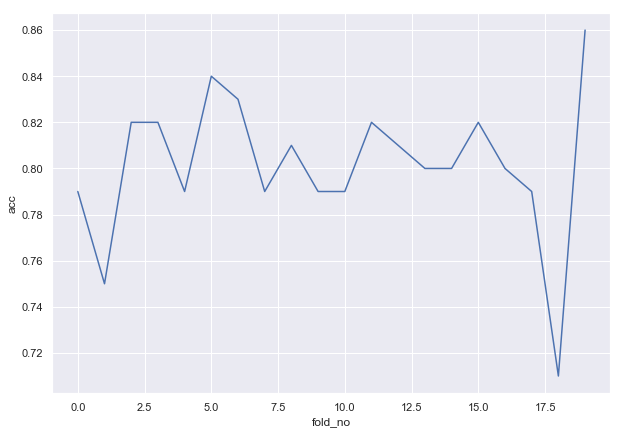

In [462]:
fig,ax=plt.subplots(figsize=(10,7))
sns.lineplot(x='fold_no',y='acc',
             data=high_iaa_res_df.loc[(high_iaa_res_df.base_model=='LM-finetuned-all-cc-uncased') & 
                                     (high_iaa_res_df.text_b=='text_b')],
           ax=ax)
# sns.lineplot(x='fold_no',y='acc',data=high_iaa_res_df.loc[high_iaa_res_df.base_model!='LM-finetuned-all-cc-uncased'],
#             ax=ax,color='r')

(array([1., 0., 1., 0., 0., 9., 6., 1., 1., 2.]),
 array([0.71 , 0.726, 0.742, 0.758, 0.774, 0.79 , 0.806, 0.822, 0.838,
        0.854, 0.87 ]),
 <a list of 10 Patch objects>)

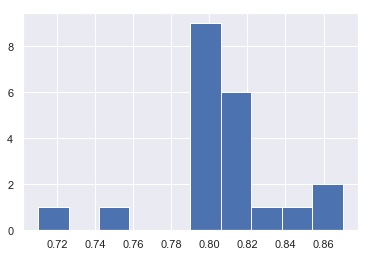

In [465]:
plt.hist(list(high_iaa_res_df.loc[(high_iaa_res_df.base_model=='LM-finetuned-all-cc-uncased') & 
                                     (high_iaa_res_df.text_b=='text_b')].acc.values)+[0.87])

(array([1., 0., 1., 0., 3., 1., 0., 2., 0., 3.]),
 array([0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85]),
 <a list of 10 Patch objects>)

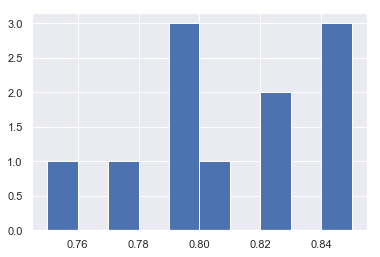

In [470]:
plt.hist(list(high_iaa_res_df.loc[(high_iaa_res_df.base_model=='LM-finetuned-all-cc-uncased') & 
                                     (high_iaa_res_df.text_b=='no_text_b') & 
                   (high_iaa_res_df.acc != -1)].acc.values)+[0.85])

In [469]:
high_iaa_res_df.loc[(high_iaa_res_df.base_model=='LM-finetuned-all-cc-uncased') & 
                                     (high_iaa_res_df.text_b=='no_text_b') & 
                   (high_iaa_res_df.acc != -1)].acc.values

array([0.79, 0.75, 0.82, 0.82, 0.79, 0.84, 0.84, 0.79, 0.8 , 0.77])